This notebook involves the code for training standard one class classification models.
The main steps followed are:\
1) Feature engineering\
2) Hyperparameter optimization\
3) k-fold cross validation\
4) Visualization of the predictions



# Importing the datasets and libraries

In [1]:
# Import the main libraries
from sklearn import datasets, metrics
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import rc
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.spatial.distance import squareform
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import KFold
from sklearn import preprocessing
from numpy import percentile
import warnings
from sklearn.preprocessing import MinMaxScaler
warnings.simplefilter("ignore", UserWarning)
from random import Random

# import rdkit libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole

# Import the standard one class models
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from sklearn.mixture import GaussianMixture


ModuleNotFoundError: No module named 'seaborn'

In [6]:
# Import the labeled dataset
dataset1 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv')
dataset2 = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv')
dataset1.head()

Identifier  ... Infective-50
0     WOVMEB  ...          0.0
1     PIWKEL  ...          1.0
2     OTIHIJ  ...          0.0
3     DABLOJ  ...          0.0
4     PIGJUK  ...          0.0

[5 rows x 1859 columns]

In [7]:
out1 = np.append(dataset2.Identifier[dataset2.NAME == 'Cc1ccccc1'].values, dataset2.Identifier[dataset2.NAME == 'c1ccccc1'].values, axis=0)
out=np.append(out1, dataset2.Identifier[dataset2.NAME == 'Cc1ccc(C)cc1'].values , axis=0)
out2 = np.append(out, dataset2.Identifier[dataset2.NAME == 'c1cc2ccc3cccc4ccc(c1)c2c34'].values, axis=0)
out3 = np.append(out2, dataset2.Identifier[dataset2.NAME == 'c1ccc2cc3ccccc3cc2c1'].values, axis=0)
out4 = np.append(out3, dataset2.Identifier[dataset2.NAME == 'Cc1cc(C)cc(C)c1'].values, axis=0)
out5 = np.append(out4, dataset2.Identifier[dataset2.NAME == 'c1ccc2ccccc2c1'].values, axis=0)

In [8]:
dataset1= dataset1[~dataset1['Identifier'].isin(out)]
dataset2 = dataset2[~dataset2['Identifier'].isin(out)]

In [9]:
data = pd.concat([dataset1.NAME, dataset2.NAME], axis=0)
data= pd.DataFrame(data.values, columns=['a'])
dat = pd.DataFrame(data['a'].value_counts())[:20]
dat


a
c1cc2ccc3cccc4ccc(c1)c2c34                          52
c1ccc2cc3ccccc3cc2c1                                27
Cc1cc(C)cc(C)c1                                     22
c1ccc2ccccc2c1                                      21
Cc1c(C)c(C)c(C)c(C)c1C                              19
Cc1ccccc1C                                          17
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45                  17
O=N(=O)c1cc(cc(c1)N(=O)=O)N(=O)=O                   16
c1ccccc1                                            15
COc1cc(C)c(c(C)c1)c1cc(c2ccc3c(cc(c4ccc1c2c34)c...  15
N#CC(C#N)=C1C=CC(C=C1)=C(C#N)C#N                    13
C1CCOC1                                             13
O=C1OC(=O)c2cc3C(=O)OC(=O)c3cc12                    12
Fc1c(F)c(F)c(F)c(F)c1F                              12
c1ccc2c(c1)c1ccccc1c1ccccc21                        11
c1ccc2c(c1)c1cccc3cccc2c13                          11
c1ccc2c(c1)ccc1ccccc21                              10
N#Cc1cc(C#N)c(cc1C#N)C#N                            10
Cc1ccccc1                                           10
c1cc2ccc3ccc4ccc5ccc6ccc1c1c2c3c4c5c61               8

In [10]:
# The two datasets are concateanted for identifing the highly correlated descriptors and remove them
df1_w=dataset1.iloc[:,2:]
df2_w=dataset2.iloc[:,2:]
data = pd.concat([df1_w, df2_w])
data_ = data.drop_duplicates(keep='first')

# Drop the highly linearly correlated features among the datasets
# Create correlation matrix
corr_matrix1 = data_.corr().abs()

# Select upper triangle of correlation matrix
upper1 = corr_matrix1.where(np.triu(np.ones(corr_matrix1.shape), k=1).astype(np.bool))

# Find index of feature columns with Pearson correlation greater than 0.92
to_drop1 = [column for column in upper1.columns if any(upper1[column] > 0.92)]

# Drop the descriptos will low variance, below 0.4
drop = data_.std()[data_.std() < 0.4].index.values
to_drop2= [x for x in drop if x not in to_drop1]
drop_final= to_drop1 + to_drop2

# Remove the selected features from the datasets
df1=df1_w.drop(columns=drop_final)
df1=df1.fillna(df1.mean())
df2=df2_w.drop(columns=drop_final)
df2=df2.fillna(df2.mean())


In [11]:
cor = df1.corrwith(df2, axis=0, drop=False, method='spearman').abs()
corr=cor.sort_values(ascending=False)


In [12]:
# Construct a vector w which is used to keep only the descriptors that are correlated higher than 0.30 using Spearman correlation
# In this vector, 1 is on the positions of the descriptors that have correlation coeficcient > 0.3,  and 0 otherwise
w = np.array(cor)
np.nan_to_num(w,0)
w[w<0.4] =0
w[w=='NaN']=0
w[w>=0.4] =1

# Multiply the two datasets with the vector w, such that the descriptors with lower correlation will become zero and removed 
df1 = df1*w
df2 = df2*w

df1_1 = df1.loc[:, (df1 != 0).any(axis=0)]
df2_2 = df2.loc[:, (df2 != 0).any(axis=0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


In [13]:
# Calculate the Pearson correlations of the datasets 
cort= df1_1.corrwith(df2_2, axis=0, drop=False, method='pearson').abs()
corrt=cort.sort_values(ascending=False)

In [14]:
# Keep only descriptors with Pearson correlations > 0.2
w = np.array(cort)
np.nan_to_num(w,0)
w[w<0.4]=0
w[w>=0.4]=1
df1_1 = df1_1*w
df2_2 = df2_2*w
df1_1 = df1_1.loc[:, (df1_1 != 0).any(axis=0)]
df2_2 = df2_2.loc[:, (df2_2 != 0).any(axis=0)]

In [15]:

from scipy.stats.stats import spearmanr
from scipy.stats.stats import pearsonr


for i in df1_1.columns.values:
  print("Descriptor:%s"% i + " " + 'Correlation:%2f' %  pearsonr(df1_1[i].values, df2_2[i].values)[0] + "  " + "p-value:%2f" %  pearsonr(df1_1[i].values, df2_2[i].values)[1])

Descriptor:nBM Correlation:-0.404334  p-value:0.000000
Descriptor:nHet Correlation:-0.519682  p-value:0.000000
Descriptor:ZM1V Correlation:-0.528533  p-value:0.000000
Descriptor:DBI Correlation:-0.548873  p-value:0.000000
Descriptor:MAXDN Correlation:-0.546764  p-value:0.000000
Descriptor:MAXDP Correlation:-0.613201  p-value:0.000000
Descriptor:DELS Correlation:-0.405218  p-value:0.000000
Descriptor:CIC0 Correlation:-0.406025  p-value:0.000000
Descriptor:J_D/Dt Correlation:-0.424448  p-value:0.000000
Descriptor:SM1_Dz(Z) Correlation:-0.561529  p-value:0.000000
Descriptor:SM1_Dz(e) Correlation:-0.492544  p-value:0.000000
Descriptor:HyWi_B(s) Correlation:-0.735810  p-value:0.000000
Descriptor:SpMax4_Bh(m) Correlation:-0.509435  p-value:0.000000
Descriptor:SpMax5_Bh(m) Correlation:-0.632145  p-value:0.000000
Descriptor:SpMax3_Bh(s) Correlation:-0.411440  p-value:0.000000
Descriptor:SpMax7_Bh(s) Correlation:-0.423908  p-value:0.000000
Descriptor:P_VSA_v_2 Correlation:-0.493104  p-value:0.0

In [16]:

dataset1=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers1.csv') 
dataset2=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/coformers2.csv') 
df1 = dataset1.iloc[:, 2:] #    # dataset1[df1_1.columns.values[:]] # 
df2 = dataset2.iloc[:, 2:] #  dataset2[df1_1.columns.values[:]]#  


In [17]:

df1 = dataset1[df1_1.columns.values[:]]
df2 = dataset2[df1_1.columns.values[:]]

In [18]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset1, dataset2):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset1, dataset2], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset2, dataset1], axis=1) ], axis=0)


In [19]:

# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
#X_scaler = StandardScaler()

df_concat = pd.concat([df1, df2])
print(df_concat.shape)
df_concat = df_concat.drop_duplicates(keep='first')
print(df_concat.shape)
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)


numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)
df =pd.concat([pd.concat([dataset1['Identifier'], df1_scaled, df2_scaled], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),df2_scaled, df1_scaled], axis=1) ], axis=0)
df


(3444, 24)
(1566, 24)


Identifier       nBM      nHet  ...  Eig04_AEA(dm)     nHAcc        Uc
0        WOVMEB  0.034483  0.000000  ...       0.667916  0.000000  0.796001
1        PIWKEL  0.057471  0.088889  ...       0.668781  0.000000  0.268420
2        OTIHIJ  0.195402  0.044444  ...       0.010378  0.000000  0.376728
3        DABLOJ  0.005747  0.044444  ...       0.715624  0.131579  0.607167
4        PIGJUK  0.074713  0.088889  ...       0.712165  0.105263  0.464233
...         ...       ...       ...  ...            ...       ...       ...
1717    AFOTIB_  0.034483  0.000000  ...       0.642404  0.236842  0.830761
1718    CIQNIC_  0.034483  0.000000  ...       0.708273  0.000000  0.000000
1719    DIVZUG_  0.034483  0.000000  ...       0.628711  0.421053  0.850892
1720    PIQTOB_  0.034483  0.000000  ...       0.424762  0.000000  0.496578
1721    RAWXEU_  0.034483  0.022222  ...       0.569472  0.157895  0.623272

[3444 rows x 49 columns]

In [92]:
df.head()

Identifier       nBM      nHet  ...  Eig04_AEA(dm).1   nHAcc.1      Uc.1
0     WOVMEB  0.034483  0.000000  ...         0.667916  0.000000  0.796001
1     PIWKEL  0.057471  0.088889  ...         0.668781  0.000000  0.268420
2     OTIHIJ  0.195402  0.044444  ...         0.010378  0.000000  0.376728
3     DABLOJ  0.005747  0.044444  ...         0.715624  0.131579  0.607167
4     PIGJUK  0.074713  0.088889  ...         0.712165  0.105263  0.464233

[5 rows x 49 columns]

In [ ]:
#df.to_csv('/content/drive/My Drive/cocrystal_design/data/df_reduced1.csv')

In [98]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 987 kB 2.9 MB/s 
     |████████████████████████████████| 59 kB 6.2 MB/s 
     |████████████████████████████████| 98 kB 6.1 MB/s 
     |████████████████████████████████| 269 kB 13.9 MB/s 
     |████████████████████████████████| 90 kB 7.0 MB/s 
     |████████████████████████████████| 95 kB 3.8 MB/s 
     |████████████████████████████████| 90 kB 6.2 MB/s 
     |████████████████████████████████| 47 kB 3.9 MB/s 
     |████████████████████████████████| 155 kB 14.2 MB/s 
     |████████████████████████████████| 77 kB 5.1 MB/s 
     |████████████████████████████████| 100 kB 7.2 MB/s 
     |████████████████████████████████| 1.3 MB 17.1 MB/s 


In [ ]:
# Generate the unknown dataset (unlabelled)

# Import the unlabeled data

link= 'https://drive.google.com/open?id=1N4qViHgTDkTMjK2NfXkc6Xo1MsQ3cbzQ'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('unlabelled_dragon.csv') 



# Read the Zinc dataset of purcasable molecules with their dragon descriptors
unlabeled = pd.read_csv('unlabelled_dragon.csv')   #('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_dragon_zinc.csv')  #  #('/content/drive/My Drive/cocrystal_design-master/data/unlabelled_dragon_zinc.csv')
#unlabeled = unlabeled[unlabeled.NAME!='ZINC000001530975']

val = unlabeled['NAME'].values
length = len(val)
print(length)
unlabeled=unlabeled.loc[:, (unlabeled != 0).any(axis=0)]


pairs = [[val[i],val[j]] for i in range(length) for j in range(length) if i!=j ]

# Remove the duplicate structures
no_dups = []
for pair in pairs:
  if not any(all(i in p for i in pair) for p in no_dups):
    no_dups.append(pair)

pairs = pd.DataFrame(no_dups)
keys = unlabeled['NAME'].values
values = unlabeled.iloc[:, 1:].values

d = {key:value for key, value in zip(keys, values)}
print(len(d['ZINC000000354958']))

1N4qViHgTDkTMjK2NfXkc6Xo1MsQ3cbzQ
209


In [ ]:
mol1_data= list()

for mol1 in pairs[0]:       
    mol1_data.append(d[mol1])
    
mol1_data = pd.DataFrame(mol1_data, columns = unlabeled.iloc[:, 1:].columns.values)   

mol2_data= list()

for mol2 in pairs[1]:   
    mol2_data.append(d[mol2])
mol2_data = pd.DataFrame(mol2_data, columns= unlabeled.iloc[:, 1:].columns.values) 

In [ ]:
final_1 = pd.concat([pairs[0],mol1_data],axis=1)
final_1 = final_1.fillna(0)
final_2 = pd.concat([pairs[1],mol2_data],axis=1)
final_2 = final_2.fillna(0)

unlab=pd.concat([pairs[0], pairs[1]], axis=1)
final_1 = final_1.replace({'#NUM!': 0})
final_2 = final_2.replace({'#NUM!': 0})

final_11=final_1[df1.iloc[:,:].columns.values]
final_22=final_2[df1.iloc[:,:].columns.values]

In [ ]:

uf=pd.concat([final_1, final_2], axis =1)

# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_1.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_1, final_2 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

uf_tot

In [ ]:
final_11=final_1[df1_1.iloc[:,:].columns.values]
final_11 = final_11.fillna(0)
final_22=final_2[df1_1.iloc[:,:].columns.values]
final_22 = final_22.fillna(0)
final_22.shape

In [ ]:
# Standarize the unlabeled data based on the labelled
final_1_scaled = pd.DataFrame(X_scaler.transform(final_11), columns=df1_1.columns.values)
final_2_scaled = pd.DataFrame(X_scaler.transform(final_22), columns=df1_1.columns.values)

uf=pd.concat([final_1_scaled, final_2_scaled], axis =1)

In [ ]:
# Define a dictionary where the comb identifier will be combined to the feature vector
comb=[]
for i in range(1,final_11.shape[0]+1):
  comb.append('comb%s' % i)

uf_tot=pd.concat([pd.DataFrame(comb, columns=['comb']),final_11, final_22 ], axis=1)

keys1 = uf_tot['comb'].values
values1 =  uf_tot.iloc[:, 1:].values

dii={key:value for key, value in zip(keys1, values1)}

In [ ]:
link='https://drive.google.com/open?id=1ZqOFKkCZwQv22FQ9JQvKM7IeGndlBSx4'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('zinc_smiles.csv') 
zinc_smiles = pd.read_csv('zinc_smiles.csv', sep=';')

ke= zinc_smiles.Identifier.str.strip()
v=zinc_smiles['smiles'].values
my_dict= {key:value for key, value in zip(ke, v)}

i=list()
for l in pairs[0]:  
  #print(my_dict[l])
  i.append(my_dict[l])

k=list()
for m in pairs[1]:
  k.append(my_dict[m])

dictionary = pd.concat([ uf_tot['comb'], pd.DataFrame(i, columns=['smiles1']), pd.DataFrame(k, columns=['smiles2']), pd.DataFrame(pairs[0]), pd.DataFrame(pairs[1])], axis=1)

In [ ]:
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}

In [ ]:
#df_final = pd.DataFrame(df.values, columns=df.columns.values)
uf_final = pd.concat([uf_tot['comb'], pd.DataFrame(uf)], axis=1)
#uf_final = pd.DataFrame(uf_final.values , columns=df.columns.values )
uf_final

In [ ]:
# Dictionary where each smiles is associated with its ZINC Identifier
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

In [ ]:
uf_final.to_pickle('/content/drive/My Drive/cocrystal_design/data/uf.final_pyod.pkl')

In [ ]:
uf_final

In [ ]:
uf_final= pd.read_pickle('/content/drive/My Drive/cocrystal_design/data/uf.final_pyod.pkl')
uf= uf_final.iloc[:, 1:]
descri_list = list(dataset1.columns.values[2:])+ (list(dataset1.columns.values[2:]))
len(descri_list)
uf = pd.DataFrame(uf.values, columns=descri_list)
uf=pd.concat([uf.iloc[:, :1857][df1_scaled.columns.values[:]],  uf.iloc[:, 1857:][df1_scaled.columns.values[:]] ], axis=1) 
uf

In [ ]:
# Unlabelled dataset
#uf_final= pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_scaled.csv')
uf= uf_final.iloc[:, 1:]
descri_list = list(dataset1.columns.values[2:])+ (list(dataset1.columns.values[2:]))
len(descri_list)
uf = pd.DataFrame(uf.values, columns=descri_list)
uf=pd.concat([uf.iloc[:, :1857][df1_scaled.columns.values[:]],  uf.iloc[:, 1857:][df1_scaled.columns.values[:]] ], axis=1) 
uf

In [ ]:
# Dictionary assinign to each combination of the unlabelled dataset the smiles of the molecular pairs
dictionary = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/dictionary.csv')
k1 = dictionary.comb
v1= dictionary.iloc[:, 1:3].values
dict1= {key:value for key, value in zip(k1, v1)}
print(dict1['comb1'])

['O=C1C=Cc2ccc3C=CC(=O)c4ccc1c2c34' 'c1cc2c3cccc4ccc5ccc(c1)c2c5c34']


In [ ]:
# Dictionary where each smiles is associated with its ZINC Identifier
zinc_smiles=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/zinc_smiles.csv')
v2= zinc_smiles.Identifier.str.strip()
k2=zinc_smiles['smiles'].values
zinc_dict= {key:value for key, value in zip(k2, v2)}

In [ ]:
# Set up the path for importing the python codes need
sys.path.extend(['/content/drive/My Drive/cocrystal_design/models',
                 '/content/drive/My Drive/cocrystal_design/notebooks/python_codes' ])


In [ ]:
# Define a function to remove duplicates

def Remove(duplicate):
  seen = set()
  result = []
  for item in duplicate:
    if item not in seen:
        seen.add(item)
        result.append(item)
        
  return result

In [ ]:
# Keep only the combinations where at least one of the molecules is one of the initials molecules (excluding fullerene as we are not interested at that point to synthesize that type of cocrystals)

initial_molecules=['c1ccc2cc3cc4cc5ccccc5cc4cc3cc2c1',                 # pentacene
                   'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc34',               # picene
                   'c1ccc2c3ccccc3c4ccccc4c2c1',                       # triphenylene
                   'c1ccc2c(c1)ccc3ccccc23',                           # phenanthrene
                   'c1ccc2c(c1)c3cccc4cccc2c34',                       # fluoranthene
                   'c1cc2ccc3ccc4ccc5ccc6ccc1c7c6c5c4c3c27',           #coronene
                   'c1ccc2c(c1)ccc1cc3cc4cc5c(ccc6ccccc65)cc4cc3cc12', #dibenzo-pentacene
                   'c1cc2ccc3ccc4ccc5ccc1c1c2c3c4c51']                #corannulene

def final_list(b):
  lista=[]
  lista1=[]
  for k in initial_molecules:
    for x in b['comb']:
      for i in range(0,2):
        if k in dict[x][i]:
          lista1.append(x)
  return Remove(lista1)   

# Data Analysis

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

     |████████████████████████████████| 987 kB 2.8 MB/s 
     |████████████████████████████████| 59 kB 6.6 MB/s 
     |████████████████████████████████| 98 kB 6.6 MB/s 
     |████████████████████████████████| 269 kB 14.4 MB/s 
     |████████████████████████████████| 90 kB 8.0 MB/s 
     |████████████████████████████████| 95 kB 3.8 MB/s 
     |████████████████████████████████| 90 kB 8.2 MB/s 
     |████████████████████████████████| 77 kB 5.3 MB/s 
     |████████████████████████████████| 47 kB 5.0 MB/s 
     |████████████████████████████████| 155 kB 16.2 MB/s 
     |████████████████████████████████| 100 kB 7.9 MB/s 
     |████████████████████████████████| 1.3 MB 16.7 MB/s 


In [ ]:
# Import the dataset which contains all the molecules that constitute the first coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link1='hhttps://drive.google.com/open?id=1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz' 
fluff, id = link1.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers1.csv') 
dataset1=pd.read_csv('coformers1.csv') 
print(dataset1.shape)

1GXCi-JWtsPjFWe25E_jUNYS1iYUZXiGz
(1722, 1859)


In [ ]:
# Import the dataset which contains all the molecules that constitute the second coformer of the extracted from CSD database and their dragon descriptors calculated after filtering with Pipeline Pilot

link2='https://drive.google.com/open?id=1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj'
fluff, id = link2.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('coformers2.csv') 
dataset2=pd.read_csv('coformers2.csv')
print(dataset2.shape)

1B9vUBhctWnJIC__-vYNPAIEJ9Y-H7vkj
(1722, 1859)


In [ ]:
df1=dataset1.iloc[:,2:]
df2=dataset2.iloc[:,2:]
df_concat = pd.concat([df1, df2])
df1 = df1.fillna(df_concat.mean())

df2 = df2.fillna(df_concat.mean())
df1=df1.dropna(axis=1)
df2=df2[df1.columns.values]


In [ ]:
# Construct the labelled dataset by contatenating the feature set of each coformer in both orders
# We have a vector of 50 dimensions now
def concat_bidirectional(dataset11, dataset22):

  return pd.concat([pd.concat([dataset1['Identifier'], dataset11, dataset22], axis=1), pd.concat([dataset1['Identifier'].apply(lambda x: f"{x}_"),dataset22, dataset11], axis=1) ])


In [ ]:
# Standarize the dataset
# Standarize the data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()

df_concat = pd.concat([df1, df2])
df_concat = df_concat.drop_duplicates(keep='first')
numerical_cols = df_concat.columns[:]
df_scaled = pd.DataFrame(X_scaler.fit(df_concat), columns=numerical_cols, index=df_concat.index)

numerical_cols = df2.columns[:]
df1_scaled =  pd.DataFrame(X_scaler.transform(df1[numerical_cols]), columns=numerical_cols, index=df1.index)
df2_scaled = pd.DataFrame(X_scaler.transform(df2[numerical_cols]), columns=numerical_cols, index=df2.index)

# Final bidirectional concatenated dataset, after feature selection and scaling 
df = concat_bidirectional(df1_scaled,df2_scaled)
df

Identifier        MW       AMW  ...  Neoplastic-50  Infective-80  Infective-50
0        WOVMEB  0.012474  0.041630  ...       0.000000      0.000000      0.000000
1        PIWKEL  0.070361  0.134320  ...       0.000000      1.000000      0.000000
2        OTIHIJ  0.164308  0.066597  ...       0.000000      0.000000      0.000000
3        DABLOJ  0.005860  0.051978  ...       0.000000      0.000000      0.000000
4        PIGJUK  0.095382  0.159366  ...       0.000000      0.000000      0.000000
...         ...       ...       ...  ...            ...           ...           ...
1717    AFOTIB_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1718    CIQNIC_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1719    DIVZUG_  0.007336  0.048022  ...       0.000000      0.000000      0.000000
1720    PIQTOB_  0.007336  0.048022  ...       0.012935      0.145605      0.014594
1721    RAWXEU_  0.002560  0.075504  ...       0.000000      0.000000      0.000000

[3444 rows x 3715 columns]

In [ ]:
#df = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/labelled_scaled.csv')
df#=df.fillna(0)

uf_final= pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_scaled.csv')
uf= uf_final.iloc[:, 1:]


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)


pc_df= df.iloc[:, 1:]
pca.fit(pc_df)
pc_df=pca.transform(pc_df)
pc_uf= pca.transform(uf.iloc[:, :])

pc_uf.shape

(21736, 3)

['67.61%', '4.95%', '2.79%']


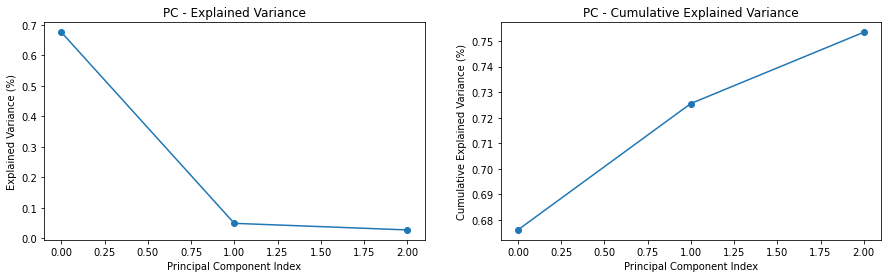

In [ ]:
sk_expl_var = np.round(pca.explained_variance_ratio_ * 100, 2)
print([f'{re}%' for re in sk_expl_var])


import matplotlib.pyplot as plt

def plot_explained_variance(pca_explained_variance_ratio_):
    fig, ax = plt.subplots(1,2,figsize=[15,4])

    ax[0].plot(pca_explained_variance_ratio_)
    ax[0].scatter(range(len(pca_explained_variance_ratio_)), pca_explained_variance_ratio_)
    ax[0].set_title('PC - Explained Variance')
    ax[0].set_xlabel('Principal Component Index')
    ax[0].set_ylabel('Explained Variance (%)');

    accumulative_expl_var = []
    for i in range(len(pca_explained_variance_ratio_)):
        accumulative_expl_var.append(np.sum(pca_explained_variance_ratio_[:i+1]))
    ax[1].plot(accumulative_expl_var)
    ax[1].scatter(range(len(accumulative_expl_var)), accumulative_expl_var)
    ax[1].set_title('PC - Cumulative Explained Variance')
    ax[1].set_xlabel('Principal Component Index')
    ax[1].set_ylabel('Cumulative Explained Variance (%)'); 
    
plot_explained_variance(pca.explained_variance_ratio_)

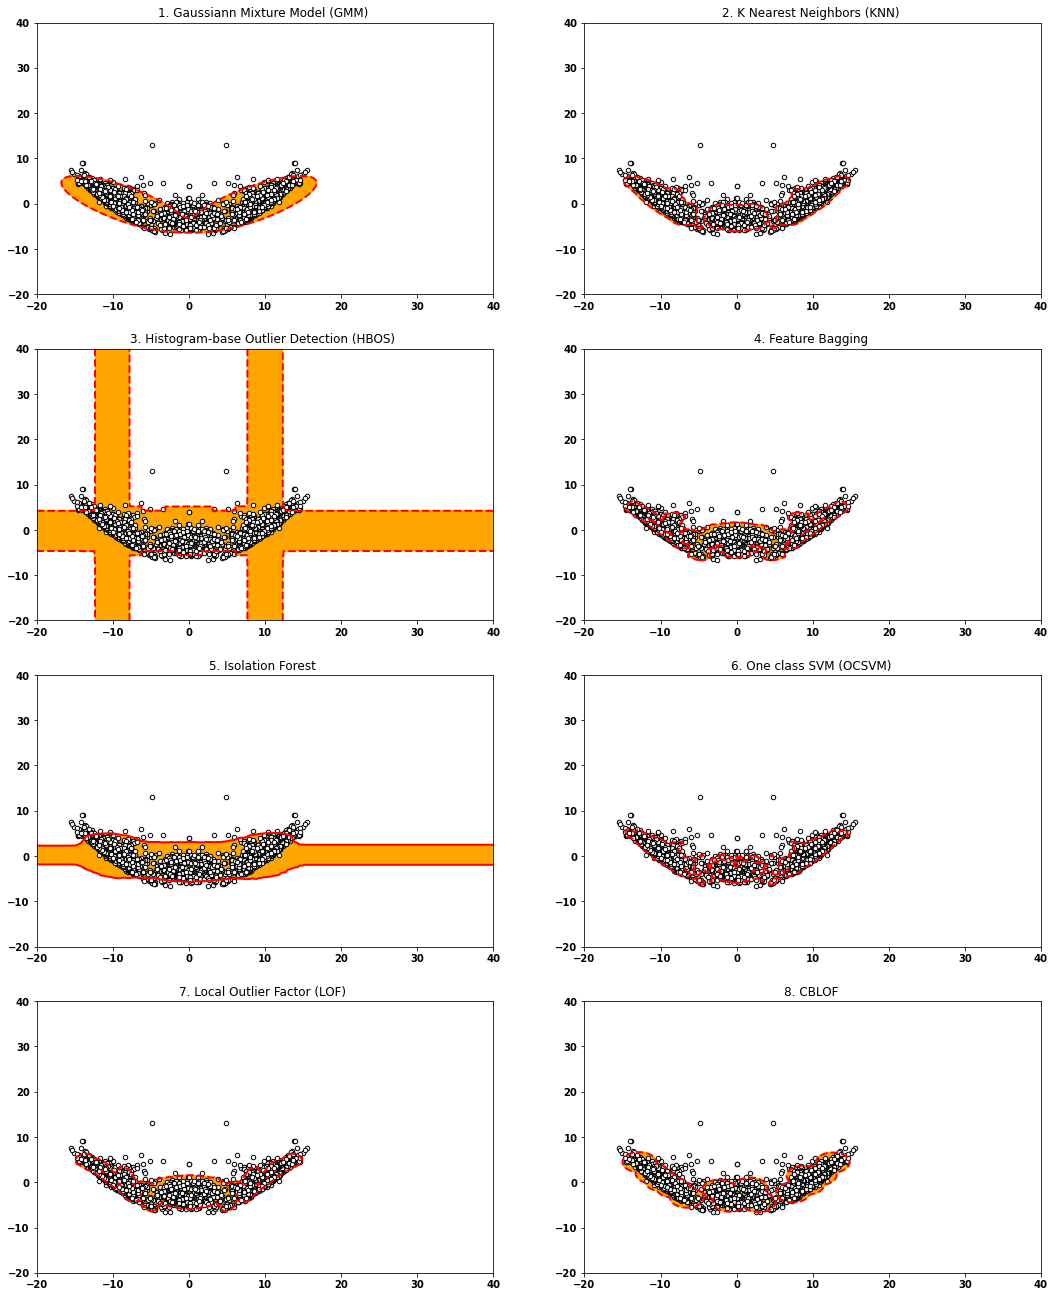

In [ ]:
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
outliers_fraction = 0.05
plt.figure(figsize=(18, 23))
for i, (clf_name, clf) in enumerate(classifiers.items()):
  subplot = plt.subplot(4, 2, i+1) 
  subplot.set_title("%d. %s " % (i + 1, clf_name))
  if clf_name == 'Gaussiann Mixture Model (GMM)':
    clf = GMM(n_components=2, covariance_type='full', random_state=0)
    clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
    xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500)) 
    scores_pred = clf.score_samples(X_train) 
    threshold = percentile(scores_pred, 100 * outliers_fraction)    
  
    Z = clf.score_samples(np.c_[xx.ravel(), yy.ravel()]) 
    Z = Z.reshape(xx.shape)
       
    
    a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')

    b  = plt.scatter(X_train[:, 0], X_train[:, 1], color='white',
                            s=20, edgecolor='k')
            
  else:
    clf.fit(X_train)
    xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))    

    scores_pred = clf.decision_function(X_train) * -1

    threshold = percentile(scores_pred, 100 * outliers_fraction)
        
  
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
    Z = Z.reshape(xx.shape)
       
    #plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 10),
     #                    cmap=plt.cm.Blues_r)
    a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
    plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')

    b  = plt.scatter(X_train[:, 0], X_train[:, 1], color='white',
                            s=20, edgecolor='k')

  #subplot.set_xlim(-5, 5)
  #subplot.set_ylim(-5, 5)


In [ ]:
classifiers = {
    'Gaussiann Mixture Model (GMM)':
       GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=5)#  CBLOF(contamination=0.05,  alpha=0.6, beta=6, n_clusters=9)

}

In [ ]:
clf1 = GMM(n_components=4, covariance_type='full', random_state=None)
clf2 =  KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree')
clf3 = HBOS(contamination=0.05, n_bins=20, alpha=0.5)
clf4 = FeatureBagging(LOF(n_neighbors=35), contamination=0.05)
clf5 = IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000)
clf6 = OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6)
clf7 = LOF(n_neighbors=35, contamination=0.05)
clf8= CBLOF(contamination=0.05, n_clusters=10)

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


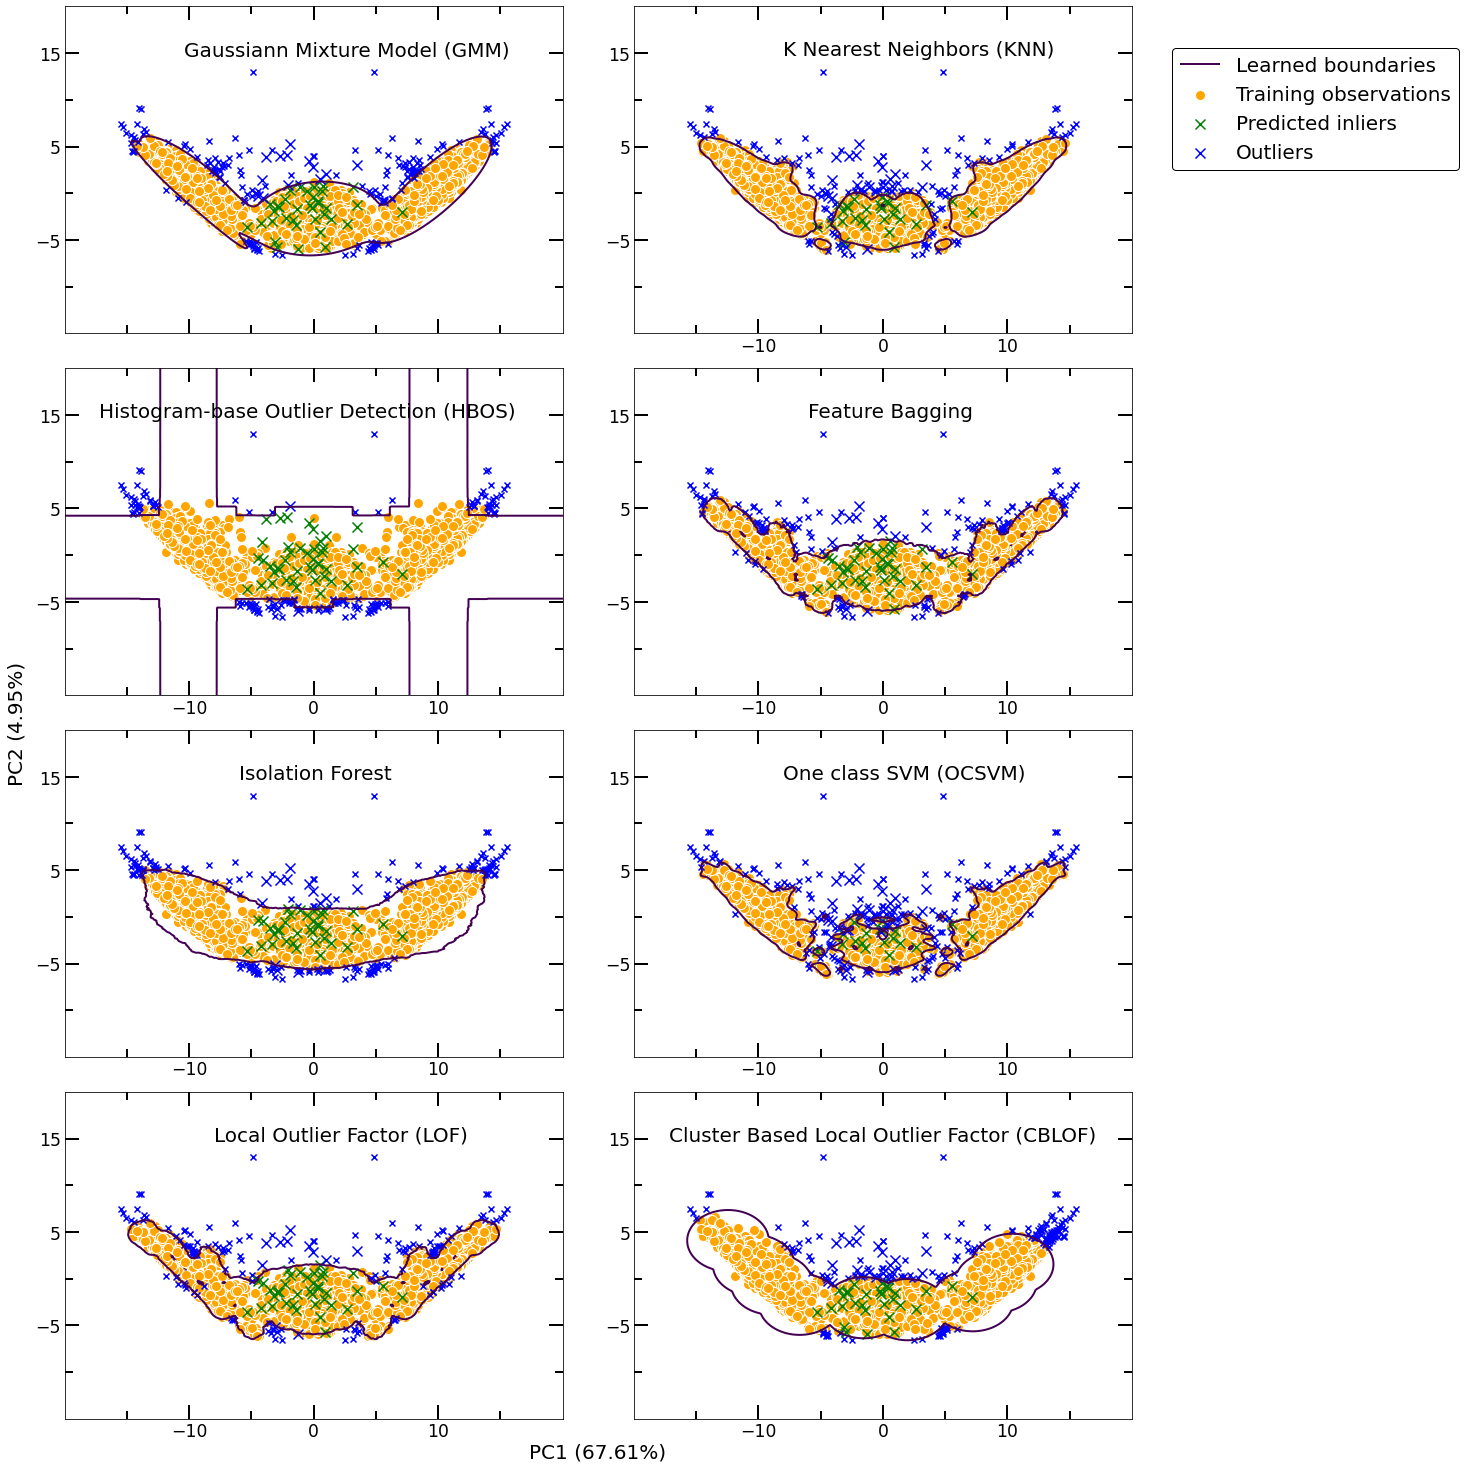

In [ ]:
import matplotlib.font_manager
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
outliers_fraction=0.05
uf_pc = pd.DataFrame(pc_uf)

### Randomly select some point from the unlabelled to plot
uf_pc = uf_pc.sample(n = 50, random_state=1)
X_test =  np.array(pd.concat([uf_pc[0],uf_pc[1]], axis=1))

fig, axes = plt.subplots(figsize=(20,20),nrows=4, ncols=2,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7 = axes.flatten() 

# GMM
clf1.fit(X_train,pd.DataFrame(np.zeros(len(X_train))))
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf1.score_samples(X_train) #* -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k1=clf1.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k1, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf1.predict(X_test)
scores_pred_t =  clf1.score_samples(X_test) #* -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf1.score_samples(np.c_[xx.ravel(), yy.ravel()]) #* -1
Z = Z.reshape(xx.shape)
a = ax0.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax0.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax0.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax0.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax0.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax0.set_xlim((-20, 20))
ax0.set_ylim((-15, 20))
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
ax0.text(0.24, 0.85, 'Gaussiann Mixture Model (GMM)', 
        transform=ax0.transAxes, ha="left", fontsize=20)
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax0.yaxis.get_minor_ticks()[-1].draw = lambda *args:None

#KNN
clf2.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf2.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf2.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf2.predict(X_test)
scores_pred_t =  clf2.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax1.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax1.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax1.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax1.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax1.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax1.set_xlim((-20, 20))
ax1.set_ylim((-15, 20))
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.text(0.3, 0.85, 'K Nearest Neighbors (KNN)', 
        transform=ax1.transAxes, ha="left", fontsize=20)
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# HBOS
clf3.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf3.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf3.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf3.predict(X_test)
scores_pred_t =  clf3.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf3.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax2.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax2.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax2.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax2.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax2.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax2.set_xlim((-20, 20))
ax2.set_ylim((-15, 20))

ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.text(0.07, 0.85, 'Histogram-base Outlier Detection (HBOS)', 
        transform=ax2.transAxes, ha="left", fontsize=20)
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



#FeatureBagging
clf4.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf4.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf4.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf4.predict(X_test)
scores_pred_t =  clf4.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf4.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax3.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax3.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax3.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax3.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax3.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax3.set_xlim((-20, 20))
ax3.set_ylim((-15, 20))
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.text(0.35, 0.85, 'Feature Bagging', 
        transform=ax3.transAxes, ha="left", fontsize=20)
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# IForest
clf5.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf5.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf5.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf5.predict(X_test)
scores_pred_t =  clf5.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf5.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax4.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax4.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax4.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax4.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax4.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax4.set_xlim((-20, 20))
ax4.set_ylim((-15, 20))
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.text(0.35, 0.85, 'Isolation Forest', 
        transform=ax4.transAxes, ha="left", fontsize=20)
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



# OCSVM
clf6.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf6.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf6.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf6.predict(X_test)
scores_pred_t =  clf6.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf6.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax5.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax5.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax5.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax5.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax5.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax5.set_xlim((-20, 20))
ax5.set_ylim((-15, 20))
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.text(0.3, 0.85, 'One class SVM (OCSVM)', 
        transform=ax5.transAxes, ha="left", fontsize=20)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# LOF
clf7.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf7.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf7.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf7.predict(X_test)
scores_pred_t =  clf7.decision_function(X_test) * -1
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf7.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax6.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax6.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax6.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax6.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax6.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax6.set_xlim((-20, 20))
ax6.set_ylim((-15, 20))
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.text(0.3, 0.85, 'Local Outlier Factor (LOF)', 
        transform=ax6.transAxes, ha="left", fontsize=20)
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_minor_ticks()[-1].draw = lambda *args:None


# CBLOF
clf8.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf8.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf8.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf8.predict(X_test)
scores_pred_t =  clf8.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf8.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax7.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax7.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax7.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax7.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax7.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax7.set_xlim((-20, 20))
ax7.set_ylim((-15, 20))
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.text(0.07, 0.85, 'Cluster Based Local Outlier Factor (CBLOF)', 
        transform=ax7.transAxes, ha="left", fontsize=20)
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_minor_ticks()[-1].draw = lambda *args:None



#plt.legend(prop={'size': 20}, loc=(0.45, 0.75), facecolor='white', framealpha=1)

ax1.legend([a.collections[0], b, c, d],
           ["Learned boundaries", "Training observations", "Predicted inliers", "Outliers"], 
           prop=matplotlib.font_manager.FontProperties(size=20),loc=(1.08, 0.5), facecolor='white', framealpha=1, edgecolor='black' )

fig.text(0.4, -0.01, 'PC1 (67.61%)', ha='center', fontsize=20)  
fig.text(-0.01, 0.5, 'PC2 (4.95%)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
plt.savefig('/content/drive/My Drive/pca_plt.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


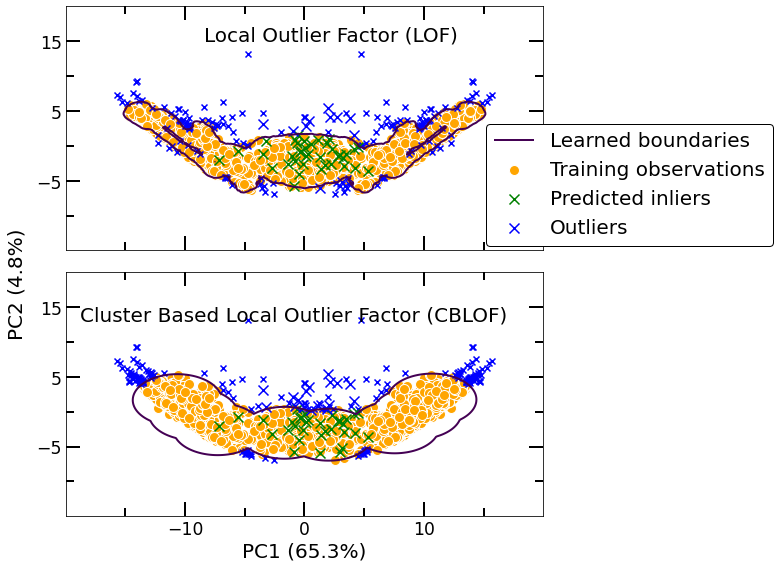

In [ ]:
import matplotlib.font_manager
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams["font.sans-serif"] = "Helvetica"
plt.rcParams["axes.labelsize"] = "xx-large"
plt.rcParams["axes.labelweight"]= "normal"
plt.rcParams["xtick.labelsize"] = "xx-large"
plt.rcParams["ytick.labelsize"] = "xx-large"
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
outliers_fraction=0.05
uf_pc = pd.DataFrame(pc_uf)

### Randomly select some point from the unlabelled to plot
uf_pc = uf_pc.sample(n = 50, random_state=1)
X_test =  np.array(pd.concat([uf_pc[0],uf_pc[1]], axis=1))


#fig, axes = plt.subplots(figsize=(10,7),nrows=2, ncols=1,constrained_layout=True)#,gridspec_kw = {'wspace':0.05, 'hspace':0.1})
#ax0, ax1 = axes.flatten()
#fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
#fig.subplots_adjust( subplot_kw=dict(box_aspect=1) )

fig = plt.figure(figsize=(10.5,8))
fig.subplots_adjust(wspace=0, hspace=0)
ax0 = fig.add_subplot(2,1,1, adjustable='box')#, aspect=0.3)
ax1 = fig.add_subplot(2,1,2)


# LOF
clf1.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf1.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k1=clf1.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k1, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf1.predict(X_test)
scores_pred_t =  clf1.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf1.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax0.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax0.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax0.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax0.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax0.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax0.set_xlim((-20, 20))
ax0.set_ylim((-15, 20))
#ax0.set_ylabel('PC2 (4.8%)', fontsize=20)
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
ax0.text(0.29, 0.86, 'Local Outlier Factor (LOF)', 
        transform=ax0.transAxes, ha="left", fontsize=20)
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax0.yaxis.get_minor_ticks()[-1].draw = lambda *args:None

# CBLOF
clf2.fit(X_train)
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))  
scores_pred =  clf2.decision_function(X_train) * -1
threshold = percentile(scores_pred, 100 * outliers_fraction)
k2=clf2.predict(X_train)
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k2, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]
k=clf2.predict(X_test)
scores_pred_t =  clf2.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]
Z = clf2.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)
a = ax1.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')
b = ax1.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='orange', marker='o', s=100, linewidths=1,  edgecolors='white')
b1 = ax1.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)
c = ax1.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100)#, linewidths=100000)
d = ax1.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=100)#, linewidths=100)
ax1.set_xlim((-20, 20))
ax1.set_ylim((-15, 20))
ax1.set_xlabel('PC1 (65.3%)', fontsize=20)
#ax1.set_ylabel('PC2 (4.8%)',  fontsize=20)
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True,  direction='in')
major_ticks_x = np.arange(-20, 20.5, 10)
minor_ticks_x = np.arange(-20, 20.5, 5)
major_ticks_y = np.arange(-15, 25, 10)
minor_ticks_y = np.arange(-15, 25, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.text(0.03, 0.8, 'Cluster Based Local Outlier Factor (CBLOF)', 
        transform=ax1.transAxes, ha="left", fontsize=20)
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.xaxis.get_major_ticks()[-1].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_minor_ticks()[-1].draw = lambda *args:None
#plt.legend(prop={'size': 20}, loc=(0.45, 0.75), facecolor='white', framealpha=1)

ax0.legend([a.collections[0], b, c, d],
           ["Learned boundaries", "Training observations", "Predicted inliers", "Outliers"], 
           prop=matplotlib.font_manager.FontProperties(size=20),loc=(0.88, 0.02), facecolor='white', framealpha=1, edgecolor='black' )
fig.text(-0.01, 0.5, 'PC2 (4.8%)', va='center', rotation='vertical', fontsize=20)

plt.tight_layout()
#plt.savefig('pca_plt.svg', dpi=600)

NameError: ignored

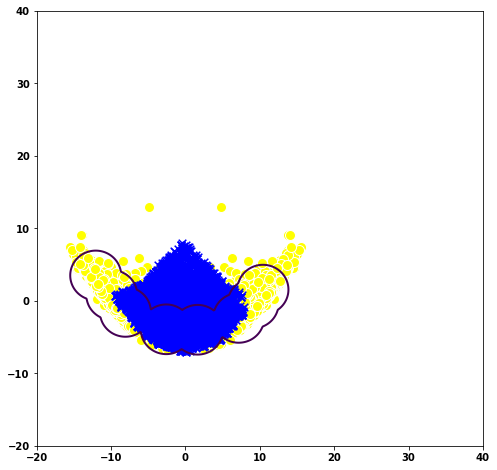

In [ ]:
from numpy import percentile
import matplotlib.font_manager
from matplotlib import rc
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

clf = CBLOF(contamination=0.05, n_clusters=10) #LOF(n_neighbors=35, contamination=0.05)
#OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma='auto') # IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000)# FeatureBagging(LOF(n_neighbors=15), contamination=0.05)
#HBOS(contamination=0.05, n_bins=20, alpha=0.3) #KNN(contamination=0.05, method='largest', n_neighbors= 40) #  LOF(n_neighbors=15, contamination=0.05) #OCSVM(contamination=0.05, kernel='rbf', nu=0.08 , degree=8, gamma='auto') #      
X_train = np.array(pd.concat([pd.DataFrame(pc_df)[0],pd.DataFrame(pc_df)[1]], axis=1))
clf.fit(X_train)
outliers_fraction=0.05


k1=clf.predict(X_train)
#print(np.count_nonzero(k1))
X_train_all = pd.concat([pd.DataFrame(X_train, columns=['PC1', 'PC2']), pd.DataFrame(k1, columns=['score'])], axis=1)
X_train_in = X_train_all[X_train_all.score==0]
X_train_out = X_train_all[X_train_all.score==1]

uf_pc = pd.DataFrame(pc_uf)
### Randomly select some point from the unlabelled to plot
uf_pc = uf_pc#.sample(n = 50, random_state=1)
X_test =  np.array(pd.concat([uf_pc[0],uf_pc[1]], axis=1))

plt.figure(figsize=(8, 8))
xx, yy = np.meshgrid(np.linspace(-20, 40, 500), np.linspace(-20, 40, 500))    

scores_pred =  clf.decision_function(X_train) * -1

threshold = percentile(scores_pred, 100 * outliers_fraction)

k=clf.predict(X_test)
scores_pred_t =  clf.decision_function(X_test) * -1
#k = (scores_pred_t  > threshold).astype('int').ravel()
X_test_all = pd.concat([pd.DataFrame(X_test, columns=['PC1', 'PC2']), pd.DataFrame(k, columns=['score'])], axis=1)
X_test_in = X_test_all[X_test_all.score==0]
X_test_out = X_test_all[X_test_all.score==1]

Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
Z = Z.reshape(xx.shape)

a = plt.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, color='red')

plt.scatter(pd.DataFrame(X_train).iloc[:, 0], pd.DataFrame(X_train).iloc[:, 1], c='yellow', marker='o', s=100, linewidths=1,  edgecolors='white')
#b = plt.scatter(X_train_in.iloc[:, 0], X_train_in.iloc[:, 1], c='yellow', marker='o', s=100, linewidths=1,  edgecolors='white')
#b1 = plt.scatter(X_train_out.iloc[:, 0], X_train_out.iloc[:, 1], c='blue', marker='x')#, s=18, linewidths=100)


plt.scatter(pd.DataFrame(X_test).iloc[:, 0], pd.DataFrame(X_test).iloc[:, 1], c='blue', marker='x', s=58, linewidths=100)#= plt.scatter(X_test_in.iloc[:, 0], X_test_in.iloc[:, 1], c='g', marker='x', s=100, linewidths=100000)
#d = plt.scatter(X_test_out.iloc[:, 0], X_test_out.iloc[:, 1], c='blue', marker='x', s=58, linewidths=100)


plt.legend([a.collections[0], b, c, d],
           ["Learned boundaries", "Training observations", "Predicted inliers", "Outliers"], loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=18))


       
plt.xlabel('Cluster Based Local Outlier Factor (CBLOF)', fontweight='bold', fontsize=18)
plt.axis('tight')
#plt.xlim((-20, 20))
#plt.ylim((-13, 20))

plt.xlim((-6, 6))
plt.ylim((-2, 6))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
#plt.savefig('cblof.jpg', rasterized=True,  dpi=1200)

In [ ]:
pd.DataFrame(X_train).iloc[:, 0]

0      -0.995207
1       0.547517
2       0.871038
3      -0.943704
4      -0.206502
          ...   
3439   -1.145427
3440   -0.950353
3441   -1.327295
3442   -0.384062
3443   -0.898620
Name: 0, Length: 3444, dtype: float64

# Evaluation of the algorithms

The selection of the hyperparameters is performed using hyperopt library and the algorithms are evaluatued using k-fold cross-validations

In [ ]:
# check the GMM classifier, the evaluation will differ there
# Built the Gaussian Mixture Classifier to be used for anomaly detection
from sklearn.base import BaseEstimator
contamination =0.05

class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X_train)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)    
    scores =(proba <= self.c).astype('int').ravel()
     
    return scores

In [ ]:
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
     FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=20, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [ ]:
def cross_val(clf1):
  valid =[]
  X_train= df.iloc[:, 1:]
  X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

  # Perform k-fold cross validation
  from sklearn.model_selection import KFold
  kf = KFold(n_splits = 5)
  kf.get_n_splits(X_train_val)

  for train, test in kf.split(X_train_val):
      train_data = np.array(X_train_val)[train]
      #print(train_data.shape)
      train_label = train_data[:,-1]
      test_data = np.array(X_train_val)[test]
      test_label = test_data[:, -1]
      clf1.fit(train_data[:, :-1],train_label )
      pred_train = clf.predict(train_data[:,:-1])
      pred_test = clf.predict(test_data[:,:-1])
      valid.append(metrics.accuracy_score(pred_test, test_label))
  print(valid)
  return valid

In [ ]:
clf = CBLOF(contamination=0.05,  alpha=0.95, beta=4, n_clusters= 15) #CBLOF(contamination=0.05,  alpha=0.9, beta=3, n_clusters= 5)
clf.fit(X_train, np.zeros(X_train.shape[0]))

CBLOF(alpha=0.95, beta=4, check_estimator=False, clustering_estimator=None,
   contamination=0.05, n_clusters=15, n_jobs=1, random_state=None,
   use_weights=False)

In [ ]:
train =clf.decision_function(X_train) * -1 
train = pd.DataFrame(train, columns =['train_score'])

k=clf.predict(uf)
print(len(k))
print(len(k)-np.count_nonzero(k))
prob_t= pd.DataFrame(k, columns=['test_label'])
prob_t= pd.concat([dictionary['comb'], prob_t], axis=1, ignore_index= False)

# Get the scores of the test data
X_test = uf
prob=clf.decision_function(X_test) * -1
prob = pd.DataFrame(prob, columns =['test_score'])
proba = pd.concat([uf_final['Identifier'], prob], axis=1, ignore_index= False)
c = train.train_score
k= proba.test_score
_, bins , _ = plt.hist(c, bins=50,  density=True, ec='k', label='Train set scores')
_= plt.hist(k, bins=bins , alpha =0.4, density=True, ec='k', label='Test set scores' )
plt.legend(prop={'size': 13})
#plt.xlim(-200, 200)

ValueError: ignored

In [ ]:
classifiers = {
    'Gaussiann Mixture Model (GMM)':
      GMM(n_components=2, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.6, beta=4, n_clusters=9)#  CBLOF(contamination=0.05,  alpha=0.6, beta=6, n_clusters=9)

}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [ ]:
from random import Random
val_list = []
df=df.fillna(0)
X_train= df.iloc[:, 1:]
X_train_val=pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(np.zeros(len(X_train)))], axis=1)

kf = KFold(n_splits = 5,   shuffle=True,  random_state=0)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  k = cross_val(clf)
  val_list.append(k)


[0.918722786647315, 0.941944847605225, 0.9114658925979681, 0.9680696661828737, 0.8997093023255814]
[0.941944847605225, 0.9477503628447025, 0.9216255442670537, 0.9492017416545718, 0.8997093023255814]
[0.8330914368650217, 0.918722786647315, 0.8577648766328012, 0.9680696661828737, 0.8880813953488372]
[0.9404934687953556, 0.9608127721335269, 0.9390420899854862, 0.9579100145137881, 0.9331395348837209]
[0.9259796806966618, 0.9216255442670537, 0.9129172714078374, 0.9506531204644412, 0.8968023255813954]
[0.9245283018867925, 0.9288824383164006, 0.9027576197387518, 0.9361393323657474, 0.8851744186046512]
[0.9477503628447025, 0.95355587808418, 0.9448476052249637, 0.9550072568940493, 0.936046511627907]
[0.9637155297532656, 0.9724238026124818, 0.9332365747460087, 0.9506531204644412, 0.9316860465116279]


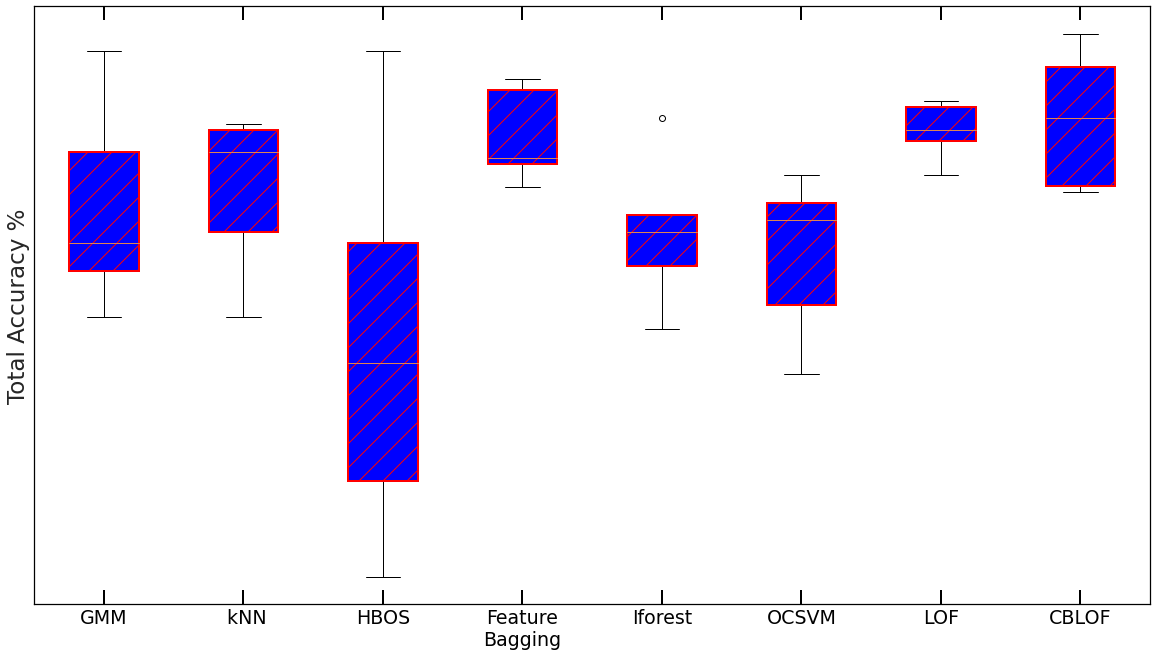

In [ ]:
# Box plot with scores
#Import the accuracies table 

# Accuracy on the known data 

model_acc = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/kfold_accuracy.csv')
data1 = val_list#[0]
# [model_acc.GMM , model_acc.kNN ,model_acc.HBOS  ,model_acc.Feat_bag ,model_acc.Iforest ,model_acc.OCSVM ,model_acc.LOF ,model_acc.CBLOF ,model_acc.Ensemble ,model_acc.DeepSVDD ]

sns.set(rc={'figure.figsize':(20 ,11)})
sns.set_style("whitegrid", {'axes.grid' : False})

fig1, ax1 = plt.subplots()
#ax1.set_ylim(70, 100)
#ax1.set_yticks([80, 90 ,100])
ax1.set_xticklabels(['GMM', ' kNN', 'HBOS', 'Feature\nBagging',   'Iforest', 'OCSVM',  'LOF', 'CBLOF', 'Ensemble', 'DeepSVDD' ])
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_y = np.arange(70, 100.1, 10)
minor_ticks_y = np.arange(70, 100.1, 5)

ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)

red_square = dict(markerfacecolor='r', marker='s')
bp0=ax1.boxplot(data1, patch_artist=True )#, showfliers=True, whis='range', vert=True,  flierprops=red_square)

for box in bp0['boxes']:
    # change outline color
    box.set(color='red', linewidth=2)
    # change fill color
    box.set(facecolor = 'blue' )
    # change hatch
    box.set(hatch = '/')
#plt.xlabel('One class classification models',  fontsize=18)
plt.ylabel('Total Accuracy %', fontsize=23 )
plt.xticks(fontsize=19)
plt.yticks(fontsize=19)
#plt.title('AUC=%.3f,   F1-score=%.3f' % (auc, f1) ,fontsize=18)
ax1.xaxis.label.set_color('black')
ax1.tick_params(axis='x', colors='black')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.spines['right'].set_color('black')

In [ ]:
import lightgbm as lgb
from hyperopt import STATUS_OK
from sklearn.model_selection import KFold
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import hp

# Create the dataset
X_train=df.iloc[:, 1:].values

# Perform k-fold cross validation
from sklearn.model_selection import KFold
X_train_val=pd.concat([pd.DataFrame(X_train), pd.DataFrame(np.zeros(len(X_train)))], axis=1)
metric=[]

def Average(lst): 
    return sum(lst) / len(lst) 

def objective(params):
  n_bins, alpha, tol = int(params['n_bins']), float(params['alpha']), float(params['tol'])
  #n_components,  covariance_type= int(params['n_components']), str(params['covariance_type']) #int(params['n_clusters']) , int(params['beta']), (params['alpha'])
  kf = KFold(n_splits = 5)
  kf.get_n_splits(X_train_val)
  
  model =  KNN(contamination=0.05, method='mean', n_neighbors= 5, metric='minkowski', algorithm='kd_tree') 
  #HBOS(contamination=0.05, n_bins= n_bins, alpha=alpha, tol=tol)
  # GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=None)
  #CBLOF(contamination=0.05, n_clusters=n_clusters, alpha=alpha, beta=beta)

  for train, test in kf.split(X_train_val):
    train_data = np.array(X_train_val)[train]
    train_label = train_data[:,-1]
    test_data = np.array(X_train_val)[test]
    test_label = test_data[:, -1]
    model.fit(train_data)
    pred_train = model.predict(train_data)
    pred_test = model.predict(test_data)
    metric.append(metrics.accuracy_score(pred_test, test_label))
    best_score = Average(metric)
    loss=1-best_score
    return {'loss':loss, 'status':STATUS_OK}

num_leaves = {'num_leaves': hp.quniform('num_leaves', 30, 150, 1)}
learning_rate={'learning_rate':hp.loguniform('learning_rate', np.log(0.001), np.log(0.01))}

space= {'alpha': hp.quniform('alpha', 0.5, 0.9, 0.1),
        'n_bins': hp.quniform('n_bins', 10, 50, 1), 
        'tol': hp.quniform('tol', 0.1, 0.9, 0.1) }
    #'contamination': hp.quniform('contamination', 0.04, 0.1, 0.02),
    #'n_clusters':hp.quniform('n_clusters', 7, 12, 1),
    #'n_components':hp.quniform('n_components', 1, 10, 1),
    #'nu': hp.quniform('nu', 0.1, 0.9, 0.1),
    #'gamma' : hp.quniform('gamma', 0.1, 0.99, 0.01)
    #'covariance_type': hp.choice('covariance_type', ['tied', 'spherical', 'full', 'diag'])}
    #'beta': hp.quniform('beta', 2, 10, 1)  }
  
tpe_algorithm =tpe.suggest
bayes_trials =Trials()
MAX_EVALS=100

# Print the hyperparameters that minimize the loss function
best_params = fmin(objective, space=space, algo=tpe.suggest, max_evals=MAX_EVALS, trials= bayes_trials)
#print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  1%|          | 1/100 [00:00<01:28,  1.12it/s, best loss: 0.06386066763425258]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  2%|▏         | 2/100 [00:01<01:27,  1.13it/s, best loss: 0.06386066763425258]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  3%|▎         | 3/100 [00:02<01:25,  1.13it/s, best loss: 0.06386066763425247]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  4%|▍         | 4/100 [00:03<01:24,  1.14it/s, best loss: 0.06386066763425247]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  5%|▌         | 5/100 [00:04<01:23,  1.14it/s, best loss: 0.06386066763425247]

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)



  5%|▌         | 5/100 [00:04<01:31,  1.04it/s, best loss: 0.06386066763425247]


KeyboardInterrupt: ignored

# Comparison

In [ ]:
classifiers = {
    'Gaussiann Mixture Model (GMM)':  GaussianMixture(n_components= 2, covariance_type='full', random_state=0), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6), #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=20, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)

}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [ ]:
def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return train_scores, test_scores
df=df.fillna(0)
X_train= df.iloc[:, 1:]
X_test = uf
train_scores, test_scores = fit_predict(X_train, X_test)

In [ ]:

gmm1 = list(train_scores[0]) + list(test_scores[0])
knn1 = list(train_scores[1]) + list(test_scores[1])
hbos1= list(train_scores[2]) + list(test_scores[2]) 
feat_bag1 = list(train_scores[3]) + list(test_scores[3])  
ifor1 =  list(train_scores[4]) + list(test_scores[4]) 
ocsvm1= list(train_scores[5]) + list(test_scores[5])  
lof1 = list(train_scores[6]) + list(test_scores[6])  
cblof1 = list(train_scores[7]) + list(test_scores[7])  


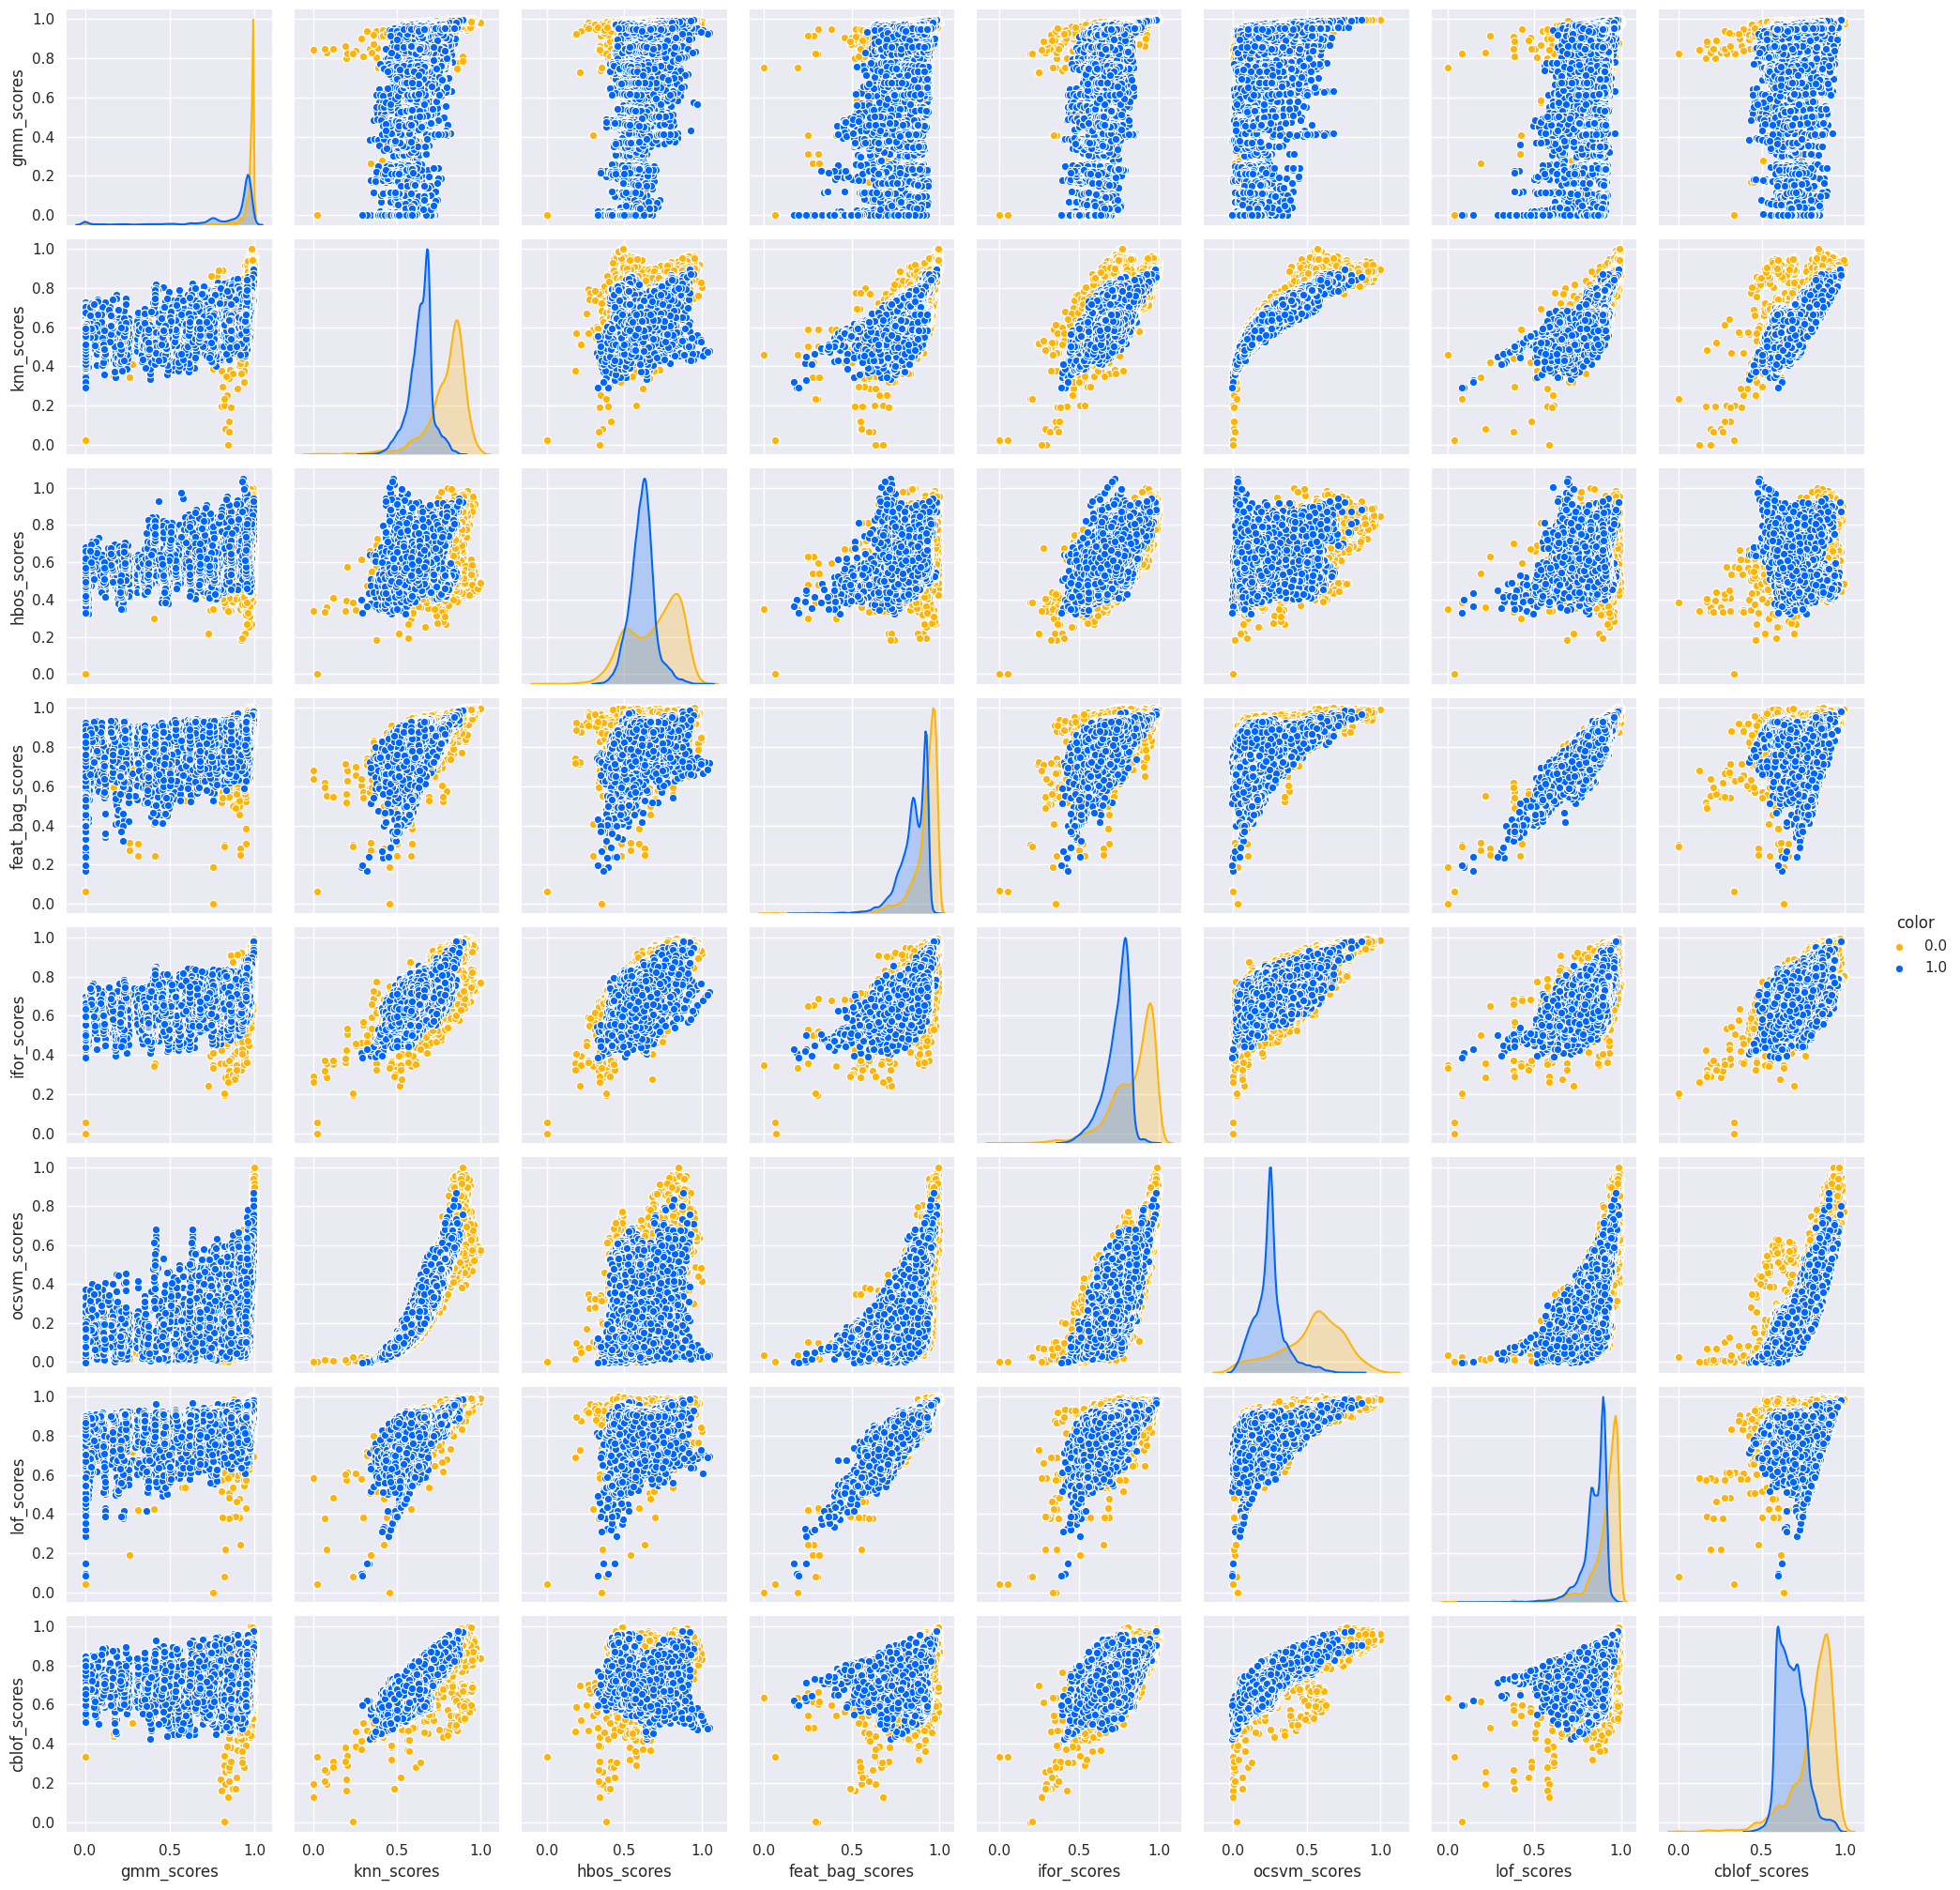

In [ ]:


label = pd.concat([pd.DataFrame(np.zeros(df.shape[0])), pd.DataFrame(np.ones(uf.shape[0]))])
sns.set_context("paper", rc={"axes.labelsize":15} )
sns.set_style("whitegrid", {'axes.grid' : False})
sns.axes_style({'xtick.color': '.8'})
sns.set(font_scale = 1.0)
scores_df = pd.DataFrame()
list2 = [0 if i < 0 else i for i in gmm1] 
scores_df['gmm_scores'] = list2 #gmm1# 
scores_df['knn_scores'] = knn1
scores_df['hbos_scores'] = hbos1
scores_df['feat_bag_scores'] = feat_bag1
scores_df['ifor_scores'] = ifor1
scores_df['ocsvm_scores'] = ocsvm1
scores_df['lof_scores'] = lof1
scores_df['cblof_scores'] = cblof1 
scores_df['color'] = label.values.ravel()
color = ['#feb308','#0165fc']
ax = sns.pairplot(scores_df, hue= 'color', palette=color);
#ax.axes[0,0].set_xlim((0, 1))
#ax.axes[0,0].set_ylim((0, 1))
sns.despine(left=True, bottom=True)

#plt.savefig('/content/drive/My Drive/figure1.jpg', rasterized=True,  dpi = 600)

In [ ]:
# Calculate the normalized scores for the classifiers
def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return train_scores, test_scores
X_train= df.iloc[:, 1:]
X_test = uf
train_scores, test_scores = fit_predict(X_train, X_test)

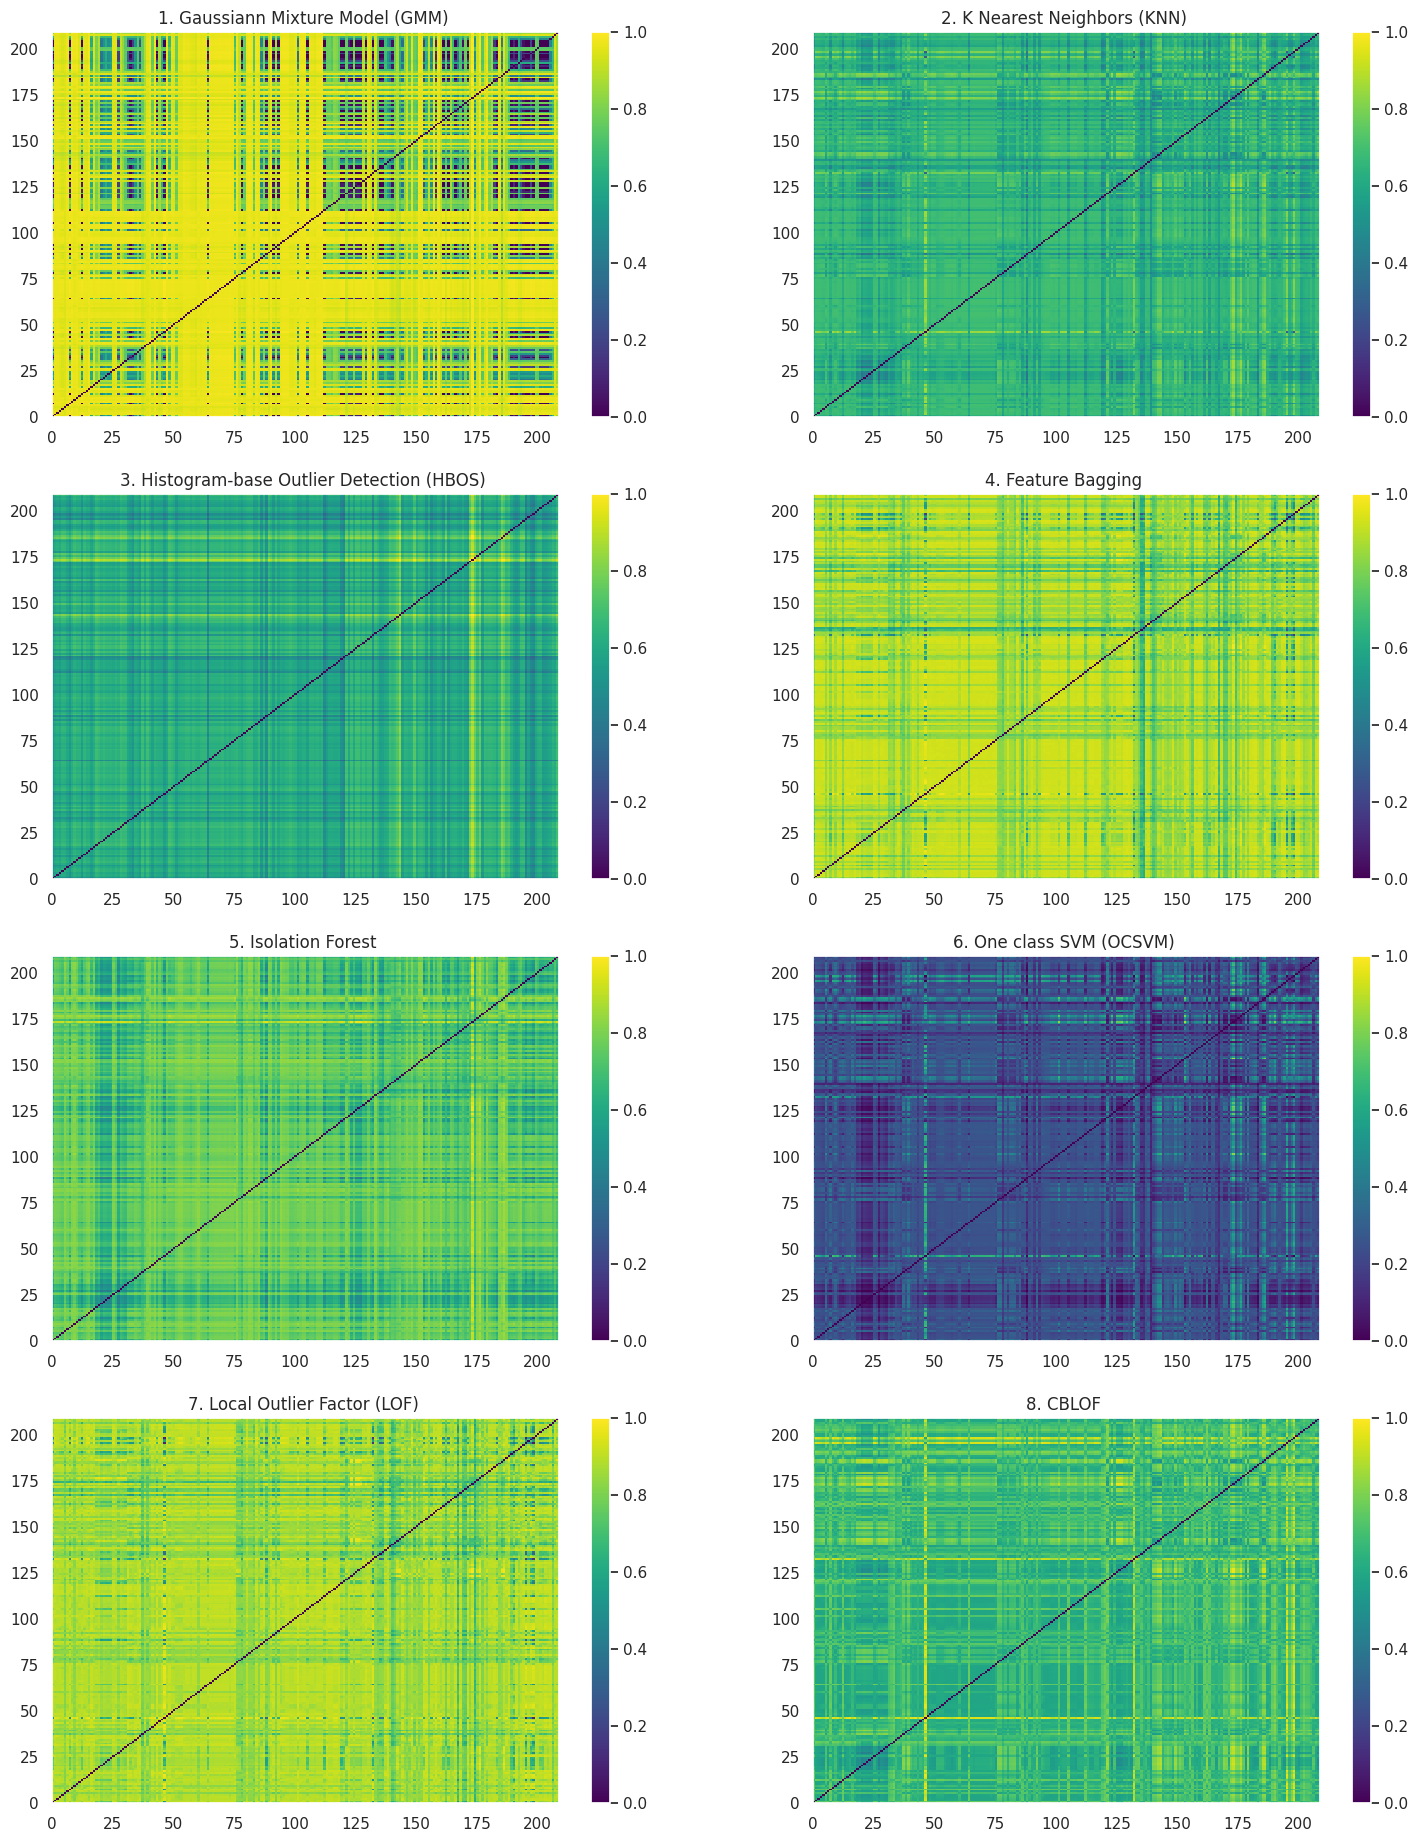

In [ ]:
# Generate the heatmaps of all the alrorithms (2 columns x 4 rows)
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"

classifier = {'Gaussiann Mixture Model (GMM)':gmm1[3444:], 'K Nearest Neighbors (KNN)':knn1[3444:], 'Histogram-base Outlier Detection (HBOS)':hbos1[3444:],
        'Feature Bagging':feat_bag1[3444:], 'Isolation Forest':ifor1[3444:], 'One class SVM (OCSVM)':ocsvm1[3444:], 'Local Outlier Factor (LOF)':lof1[3444:] , 'CBLOF':cblof1[3444:]}

plt.figure(figsize=(18, 23))
for i, (clf_name, clf) in enumerate(classifier.items()):
  dist_mat = squareform(clf)
  subplot = plt.subplot(4, 2, i+1)
  N = dist_mat.shape[0]
  cmap = plt.get_cmap('viridis')
  plt.pcolormesh(dist_mat, cmap=cmap)
  plt.colorbar()
  plt.clim(0,1)
  subplot.set_title("%d. %s " % (i + 1, clf_name))

#plt.savefig('/content/drive/My Drive/cocrystal_design/notebooks/python_codes/figures/heatmaps.png', dpi=600)

# Scoring

The final scoring is performed using the ensemble of all the models for more accurate and robust predictions

In [ ]:
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6), #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=25), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)

}

In [ ]:

classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components=4, covariance_type='full', random_state=None), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=9)#  CBLOF(contamination=0.05,  alpha=0.6, beta=6, n_clusters=9)

}

In [95]:
classifiers = {
   'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
      # GaussianMixture(n_components=4, covariance_type='full', random_state=None),
   'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),

    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=15), #alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=200,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF':  CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [96]:
# Find the average score of all the algorithms (Ensemble scores)

from sklearn import preprocessing
from numpy import percentile
from pyod.models.combination import aom, moa, average, maximization

def fit_predict(X_train, X_test):
  train_scores=[]
  test_scores = []
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
  contamination = 0.05
  for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    if clf_name == 'Gaussiann Mixture Model (GMM)':
      clf.fit(X_train, pd.DataFrame(np.zeros(len(X_train))))
      prob = clf.score_samples(X_train)
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.score_samples(X_test)
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1))
      c=percentile(prob, 100 * contamination) #pd.DataFrame(proba_t.describe().loc['75%'].astype(float)).iloc[0].values[0]
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
    else:
      clf.fit(X_train)
      prob=clf.decision_function(X_train) * -1 
      prob = min_max_scaler.fit_transform(np.array(prob).reshape(-1,1))
      prob_t  = clf.decision_function(X_test) * -1
      prob_t = min_max_scaler.transform(np.array(prob_t).reshape(-1,1)) 
      c=percentile(prob, 100 * contamination) #pd.DataFrame(proba_t.describe().loc['75%'].astype(float)).iloc[0].values[0]
      train_scores.append(prob.ravel())
      test_scores.append(prob_t.ravel())
  return average(np.transpose(train_scores)), average(np.transpose(test_scores)) #train_scores, test_scores  # 

X_train= df.iloc[:, 1:]
X_test = uf
train_scores_av, test_scores_av = fit_predict(X_train, X_test)
lab=pd.DataFrame(train_scores_av, columns=['train_score'])
unlab=pd.DataFrame(test_scores_av, columns=['test_score'])

NameError: ignored

In [ ]:
y_scaler = MinMaxScaler(feature_range=(0,1) )
c = train_scores_av # final_score_t['t_score']
k= test_scores_av #final_score['score']

c1 = y_scaler.fit_transform(c.ravel().reshape(-1,1))
k1 =  y_scaler.transform(k.ravel().reshape(-1,1))

In [ ]:
# save the scores in a csv

model_scores = pd.concat([pd.DataFrame(gmm1, columns=['gmm1']),pd.DataFrame(knn1, columns=['knn1']), pd.DataFrame(hbos1, columns=['hbos1']), pd.DataFrame(feat_bag1, columns=['feat_bag']),
           pd.DataFrame(ifor1, columns=['ifor1']), pd.DataFrame(ocsvm1, columns=['ocsvm1']), pd.DataFrame(lof1, columns=['lof1']), pd.DataFrame(cblof1, columns=['cblof1'])  ,
           pd.DataFrame(np.concatenate([c1, k1]).ravel(), columns=['ens'])] , axis=1)

model_scores#.to_csv('/content/drive/My Drive/cocrystal_design/data/model_scores_new.csv')           

gmm1      knn1     hbos1  ...      lof1    cblof1       ens
0      0.920232  0.557694  0.559554  ...  0.803364  0.648986  0.561956
1      0.262835  0.342286  0.540174  ...  0.191087  0.615545  0.314375
2      0.996661  0.933331  0.940285  ...  0.982340  0.947528  0.945652
3      0.741361  0.597889  0.345870  ...  0.612294  0.764328  0.474960
4      0.313331  0.500046  0.479742  ...  0.419243  0.663105  0.262157
...         ...       ...       ...  ...       ...       ...       ...
25175  0.947739  0.665413  0.573910  ...  0.904152  0.673887  0.650684
25176  0.859637  0.638360  0.645644  ...  0.893792  0.632482  0.617421
25177  0.941710  0.629710  0.613203  ...  0.814069  0.656468  0.595676
25178  0.847314  0.634258  0.684937  ...  0.792544  0.680381  0.581915
25179  0.947478  0.665393  0.668108  ...  0.894339  0.592765  0.671831

[25180 rows x 9 columns]

NameError: ignored

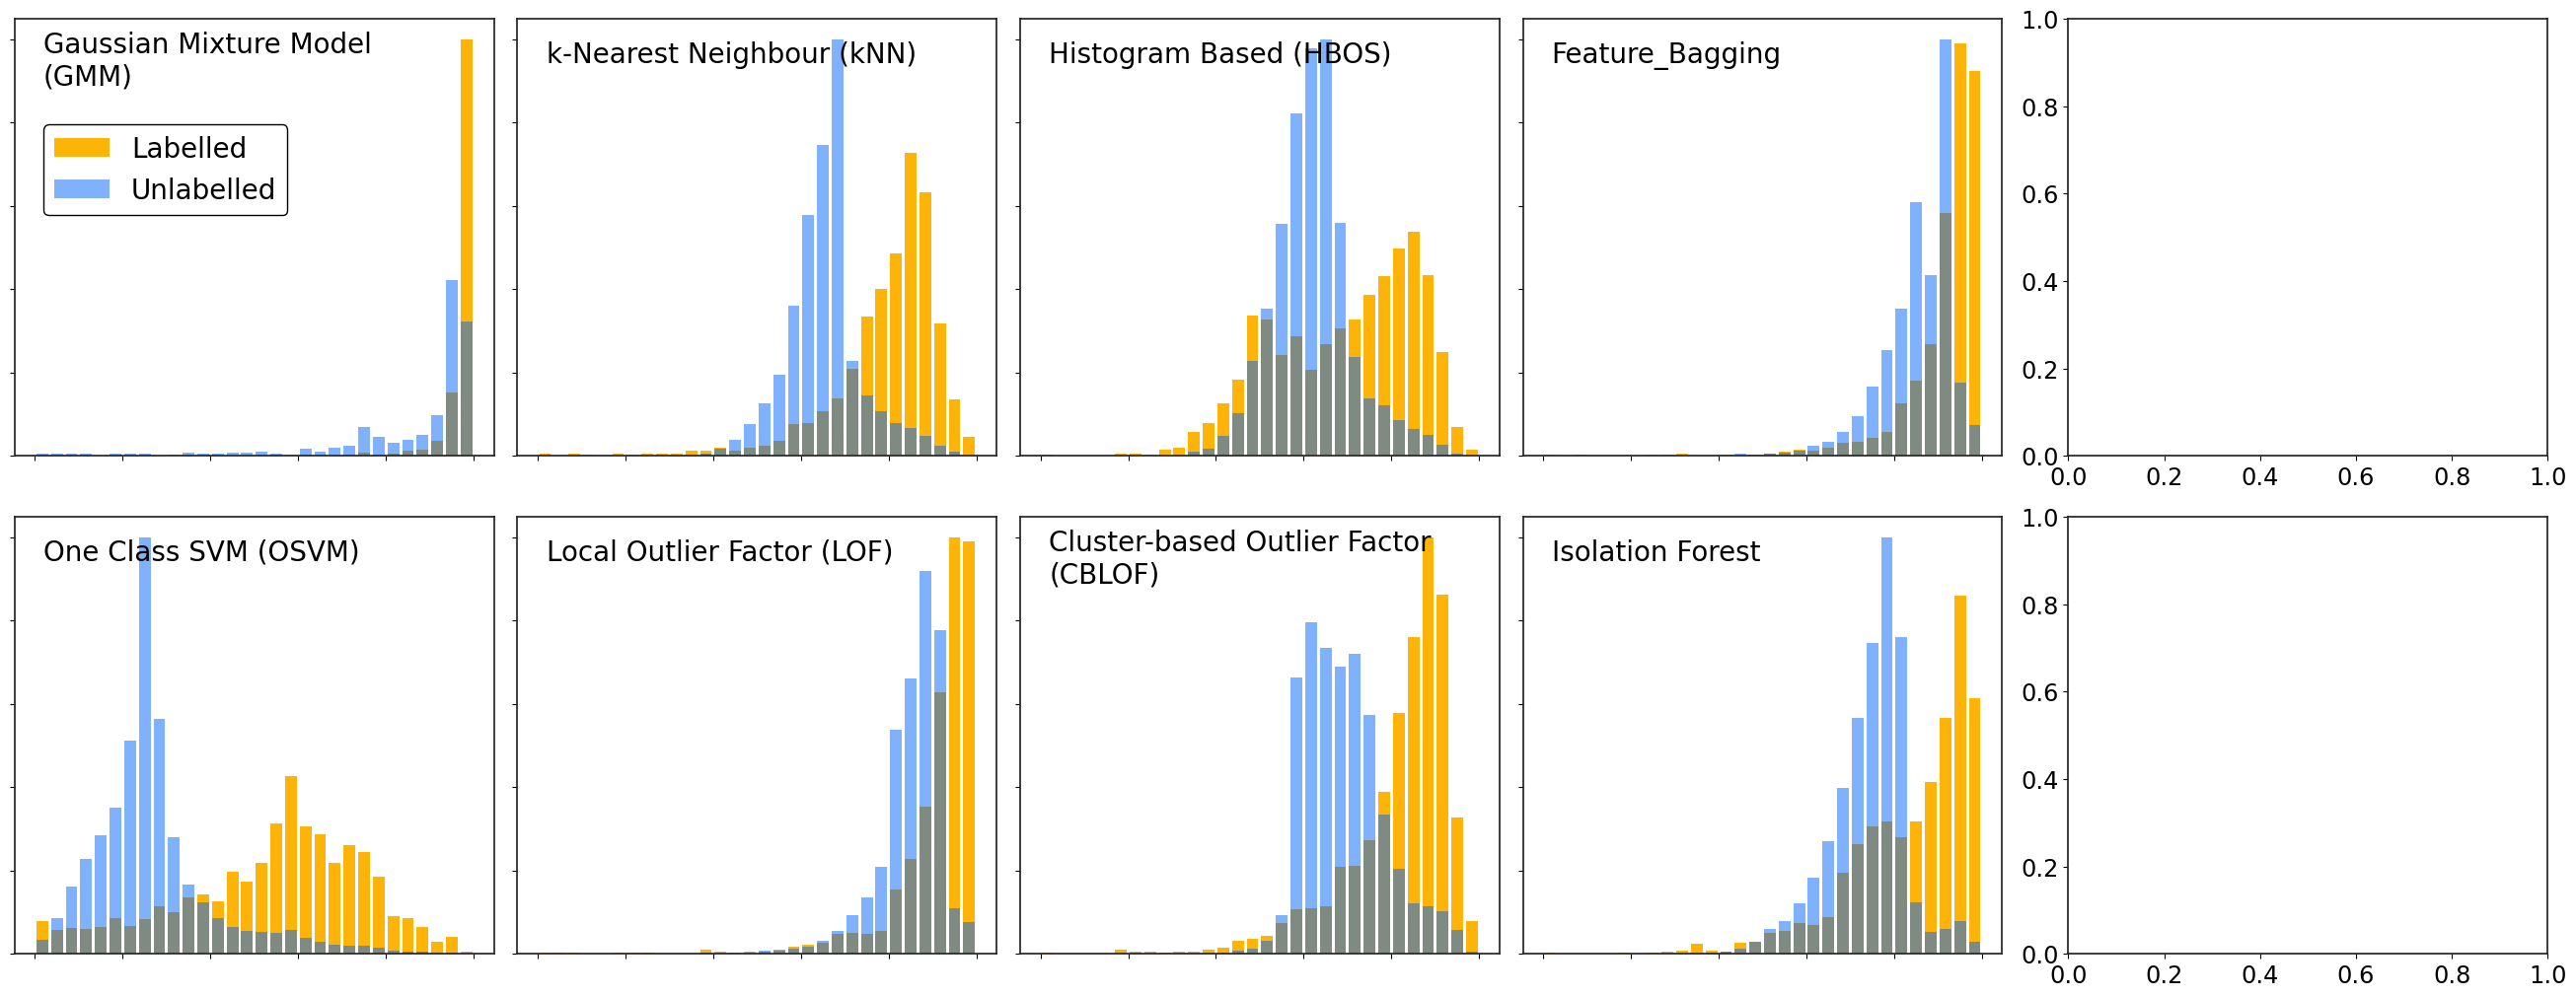

In [ ]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
import matplotlib.font_manager
from matplotlib import rcParams
import matplotlib.pyplot as plt


fig, axes = plt.subplots(figsize=(26, 10), nrows=2, ncols=5,
                         constrained_layout=True, gridspec_kw={'wspace': 0.05, 'hspace': 0.1})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"] = "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"


major_ticks_x = np.arange(0, 1.1, 0.5)
minor_ticks_x = np.arange(0, 1.1, 0.25)
major_ticks_y = np.arange(0, 1.1, 0.5)
minor_ticks_y = np.arange(0, 1.1, 0.25)

n_bins = 30


def set_ticks(ax):
    ax.tick_params(axis='both', which='both', direction="in", width=2)
    ax.tick_params(axis='both', which='major', direction="in",  length=14)
    ax.tick_params(axis='both', which='minor', length=8,
                   direction="in",  color='black')
    ax.tick_params(axis='both', which='both', bottom=True,
                  top=True, left=True, right=True, direction="in")
    ax.set_xticks(major_ticks_x)
    ax.set_xticks(minor_ticks_x, minor=True)
    ax.set_yticks(major_ticks_y)
    ax.set_yticks(minor_ticks_y, minor=True)
    #ax.tick_params(axis='both', top='off', bottom='off', left='off', right='off')
    #ax.xaxis.set_ticks_position('none') 
    #ax.yaxis.set_ticks_position('none') 
    #ax.set_xticks([], minor=True)
    #ax.set_yticks([], minor=True)


def set_spines(ax):
    ax.spines['bottom'].set_color('black')
    ax.spines['top'].set_color('black')
    ax.spines['right'].set_color('black')
    ax.spines['left'].set_color('black')


def set_prop(ax):
    ax.axis(aspect='equal')
    ax.set(adjustable='box')  # , aspect='equal')
    ax.set_xlim(0, 1.05)
    ax.set_ylim(0, 1.14)
    ax.grid(False)
    set_spines(ax)
    ax.set_facecolor('xkcd:white')
    ax.axis('on')
    #set_ticks(ax)

def norm_plot(ax, x, y, alpha=1, **kwargs):
    hist, bins = np.histogram(x, **kwargs)
    hist1, _ = np.histogram(y, **kwargs)
    n_max = np.max([hist, hist1])
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist / n_max, align='center', width = width, alpha=alpha)
    return hist, n_max


def lab_unlab_plot(ax, lab_d, unlab_d, n_bins):
    hist_lab, bins_lab = np.histogram(lab_d, bins=n_bins, density=True, range=(0,1))
    hist_unlab, bins_unlab = np.histogram(unlab_d, bins=n_bins, density=True, range=(0,1))
    n_max = np.max([hist_lab, hist_unlab])
    width_lab = 0.8 * (bins_lab[1] - bins_lab[0])
    width_unlab = 0.8 * (bins_unlab[1] - bins_unlab[0])
    center_lab = (bins_lab[:-1] + bins_lab[1:]) / 2
    center_unlab = (bins_unlab[:-1] + bins_unlab[1:]) / 2
    ax.bar(center_lab, hist_lab / n_max, align='center', width=width_lab, alpha=1, color='#feb308', label = 'Labelled')
    ax.bar(center_unlab, hist_unlab / n_max, align='center', width=width_unlab, alpha=0.5, color='#0165fc', label = 'Unlabelled')



# Gaussian Mixture Model
lab_unlab_plot(ax0, model_scores.gmm1[:3444], model_scores.gmm1[3444:], n_bins)
# ax0.axis(aspect='equal')
ax0.text(0.06, 0.85, 'Gaussian Mixture Model\n(GMM)',
         transform=ax0.transAxes, ha="left", fontsize=20)
#ax0.legend(prop={'size': 20}, loc=(0.02, 0.65), facecolor='white', framealpha=0)
ax0.legend(prop={'size': 20}, loc=(0.06, 0.55), facecolor='white', edgecolor='black', framealpha=1)#,  borderpad=1 ) #shadow=True, fancybox=True, loc=(0.75, -0.15),
ax0.set_xticklabels([])
ax0.set_yticklabels([])

# knn
n_bins = 30
lab_unlab_plot(ax1, model_scores.knn1[:1722], model_scores.knn1[1722:], n_bins)
ax1.text(0.06, 0.9, 'k-Nearest Neighbour (kNN)',
         transform=ax1.transAxes, ha="left", fontsize=20)
#ax1.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax1.set_xticklabels([])
ax1.set_yticklabels([])

# HBOS
lab_unlab_plot(ax2, model_scores.hbos1[:1722], model_scores.hbos1[1722:], n_bins)
ax2.text(0.06, 0.9, 'Histogram Based (HBOS)',
         transform=ax2.transAxes, ha="left", fontsize=20)
#ax2.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax2.set_xticklabels([])
ax2.set_yticklabels([])

# Feature Bagging
lab_unlab_plot(ax3, model_scores.feat_bag[:1722], model_scores.feat_bag[1722:], n_bins)
ax3.text(0.06, 0.9, 'Feature_Bagging',
         transform=ax3.transAxes, ha="left", fontsize=20)
#ax3.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

# Isolation Forest
lab_unlab_plot(ax8, model_scores.ifor1[:1722], model_scores.ifor1[1722:], n_bins)
ax8.text(0.06, 0.9, 'Isolation Forest',
         transform=ax8.transAxes, ha="left", fontsize=20)
#ax8.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax8.set_xticklabels([])
ax8.set_yticklabels([])

# OCSVM
lab_unlab_plot(ax5, model_scores.ocsvm1[:1722], model_scores.ocsvm1[1722:], n_bins)
ax5.text(0.06, 0.9, 'One Class SVM (OSVM)',
         transform=ax5.transAxes, ha="left", fontsize=20)
#ax5.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

# LOF
lab_unlab_plot(ax6, model_scores.lof1[:1722], model_scores.lof1[1722:], n_bins)
ax6.text(0.06, 0.9, 'Local Outlier Factor (LOF)',
         transform=ax6.transAxes, ha="left", fontsize=20)
#ax6.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax6.set_xticklabels([])
ax6.set_yticklabels([])


# CBLOF
lab_unlab_plot(ax7, model_scores.cblof1[:1722], model_scores.cblof1[1722:], n_bins)
ax7.text(0.06, 0.85, 'Cluster-based Outlier Factor\n(CBLOF)',
         transform=ax7.transAxes, ha="left", fontsize=20)
#ax7.legend(prop={'size': 20}, loc=(0.02, 0.65),
 #          facecolor='white', framealpha=0)
ax7.set_xticklabels([])
ax7.set_yticklabels([])

# DeepSVDD
lab_unlab_plot(ax9, lab_deep_scores.train_score, unlab_deep_scores.test_score, n_bins)
ax9.text(0.06, 0.9, 'Deep One Class',
         transform=ax9.transAxes, ha="left", fontsize=20)
#ax9.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax9.set_xticklabels([])
ax9.set_yticklabels([])

# Ensemble
lab_unlab_plot(ax4, ensemble_scores.ens[:1722], ensemble_scores.ens[1722:], n_bins)
ax4.text(0.06, 0.9, 'Ensemble of Standard Models', 
        transform=ax4.transAxes, ha="left", fontsize=20)
#ax4.legend(prop={'size': 20}, loc=(0.02, 0.7), facecolor='white', framealpha=0)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

for ax in axes.flatten():
  set_prop(ax)
  set_ticks(ax)

fig.tight_layout()


fig.text(0.5, -0.05, 'Nornalized Score', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'Normalized Frequency', va='center', rotation='vertical', fontsize=20)
#plt.savefig('figure2_new.png', rasterized=True,  bbox_inches="tight", dpi=600)

plt.show()


In [ ]:
#prob = pd.DataFrame(k1.ravel(), columns =['test_score'])
#proba = pd.concat([uf_final['Identifier'], prob.test_score ], axis=1, ignore_index= False)  # unlab_deep  prob


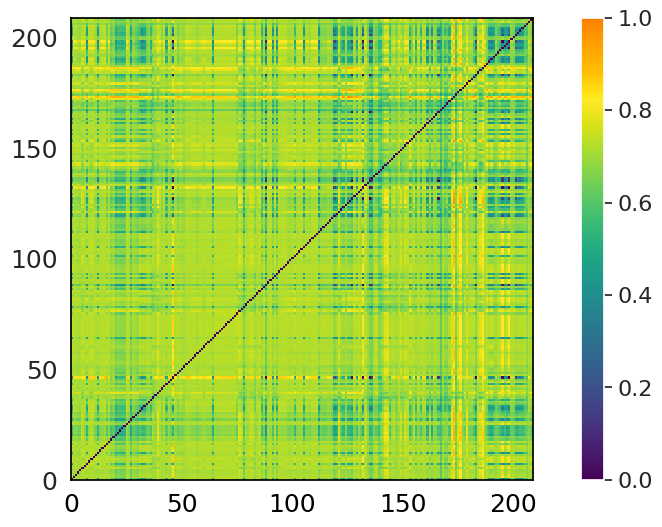

In [ ]:

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
dist_mat = squareform(k1.ravel())
N = dist_mat.shape[0]

#viridis = cm.get_cmap('viridis', 256)
#newcolors = viridis(np.linspace(0, 1, 256))
#orange = np.array([1, 148/256, 24/256,  248/256])
#newcolors[180:256, :] = orange
#newcmp = ListedColormap(newcolors)

#viridisBig = cm.get_cmap('viridis', 512)
#newcmp = ListedColormap(viridisBig(np.linspace(0.1, 0.75, 256)))

top = cm.get_cmap('viridis', 512)
bottom = cm.get_cmap('Wistia', 512)

newcolors = np.vstack((top(np.linspace(0, 1, 812)),
                       bottom(np.linspace(0.2, 1, 180))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')



cmap = plt.get_cmap('viridis')
plt.pcolormesh(dist_mat, cmap=  newcmp)  #newcmp )#

cbar = plt.colorbar()
plt.clim(0,1) 
#plt.colorbar(shrink=1)
cbar.ax.tick_params(labelsize=16) 
plt.xlim([0,N])
plt.ylim([0,N])

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.xaxis.label.set_color('black')
ax.tick_params(axis='x', colors='black')
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')
plt.axis('scaled')

plt.show()

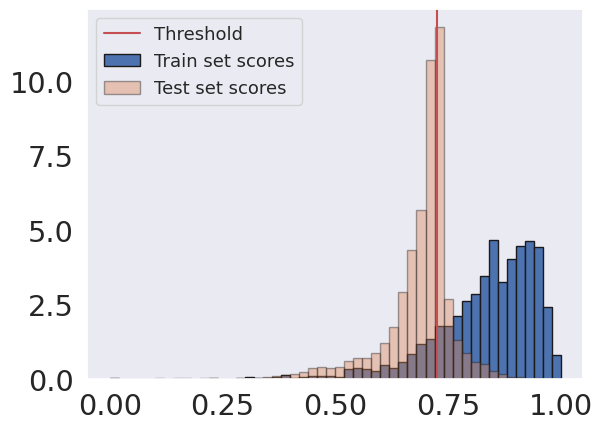

In [ ]:
_, bins , _ = plt.hist(c1, bins=50 , density = True, range=[0, 1], ec='k', label='Train set scores')
_= plt.hist(k1, bins=bins , alpha =0.4, density=True, ec='k', label='Test set scores' )
_ = plt.axvline(x= 0.726, label='Threshold', c='r')
plt.grid(False)
plt.legend(prop={'size': 13})
plt.show()

# Visualization of the predictions

In [ ]:
#uf_final = pd.DataFrame(uf_final.values, columns=df.columns.values)

In [ ]:
top=pd.concat([uf_final['Identifier'], pd.DataFrame(k, columns=['test_score'] )], axis=1)  #k1
top

Identifier  test_score
0          comb1    0.706262
1          comb2    0.700033
2          comb3    0.692152
3          comb4    0.670864
4          comb5    0.713133
...          ...         ...
21731  comb21732    0.695826
21732  comb21733    0.655381
21733  comb21734    0.662842
21734  comb21735    0.643272
21735  comb21736    0.705205

[21736 rows x 2 columns]

In [ ]:
c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['test_score'], ascending=True)
b = top[top['test_score'] > c]
b=b.sort_values(by = ['test_score'], ascending=False)
print(c)
len(b)

0.7156233134070215


5434

In [ ]:
both=[]
for x in b['Identifier']:
  if dict1[x][0] in initial_molecules:
    if dict1[x][1] in initial_molecules:
      both.append(x)
        
  if dict1[x][1] in initial_molecules:
    if dict1[x][0] in initial_molecules:
      both.append(x)
both = Remove(both)
len(Remove(both))

13

In [ ]:
one=[]
for x in b['Identifier']:#predictions:#b.comb:
 
  if dict1[x][0] in initial_molecules:
    one.append(x)
         
  else:
    if dict1[x][1] in initial_molecules:
      one.append(x)

one=Remove(one)

26


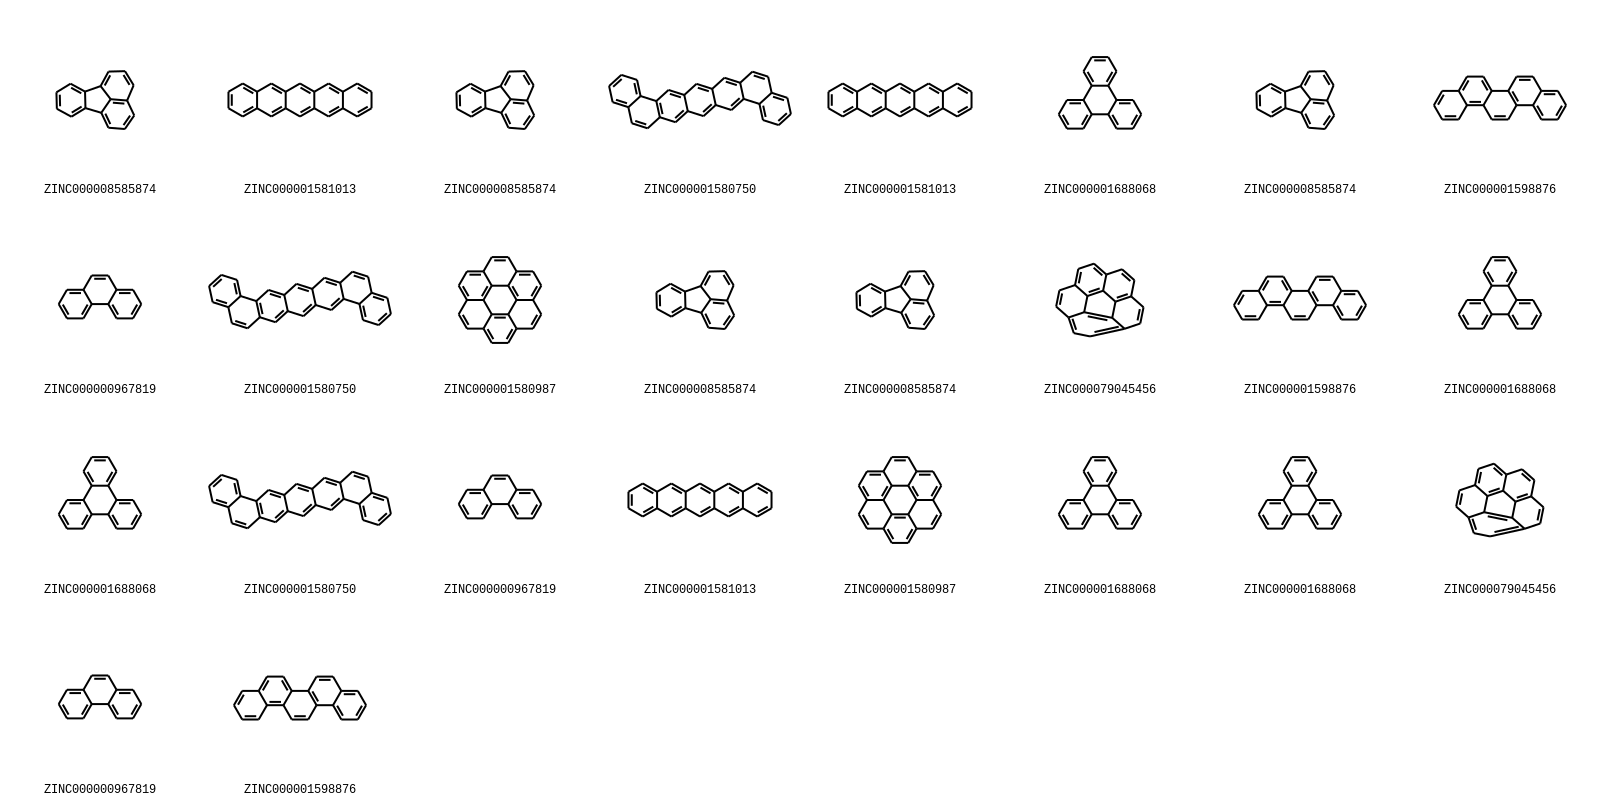

In [ ]:
listaki=[]
score=[]

for i in both:
  listaki.append(dict1[i])
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))

subms = [Chem.MolFromSmiles(x) for x in merged]

print(len(subms))


img=Draw.MolsToGridImage(subms,molsPerRow=8,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img

Number of combinations: 3


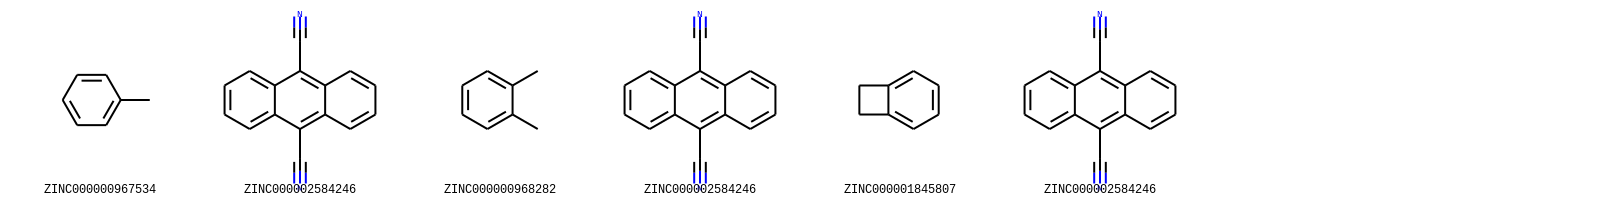

In [ ]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 
tetracene=[]
for x in b.Identifier:
  if dict1[x][0] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # if you want to check other molecules just change the two smiles here
    tetracene.append(x)        
  if dict1[x][1] == 'N#Cc1c2ccccc2c(C#N)c3ccccc13':     # and here
    tetracene.append(x)

tetracene= Remove(tetracene)    
print('Number of combinations:', len(tetracene))
listaki=[]
score=[]

for i in tetracene[:]:                     # select the number of the predictions you want to see
  #score.append(b[b.comb ==i].test_score)#score.append(b[b.comb ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=8,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img

Number of combinations: 3


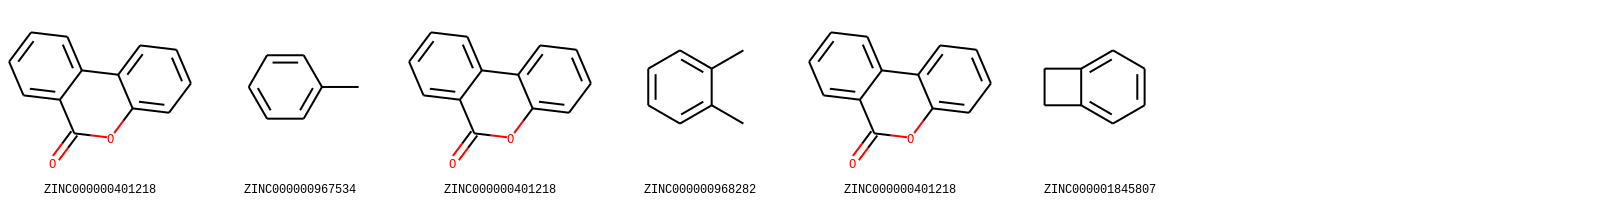

In [ ]:
tetracene=[]
for x in b.Identifier:
  if dict1[x][0] == 'O=C1Oc2ccccc2c3ccccc13':     # if you want to check other molecules just change the two smiles here
    tetracene.append(x)        
  if dict1[x][1] == 'O=C1Oc2ccccc2c3ccccc13':     # and here
    tetracene.append(x)

tetracene= Remove(tetracene)    
print('Number of combinations:', len(tetracene))
listaki=[]
score=[]

for i in tetracene[:]:                     # select the number of the predictions you want to see
  #score.append(b[b.Identifier ==i].test_score)#score.append(b[b.comb ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=8,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img

Number of combinations: 103


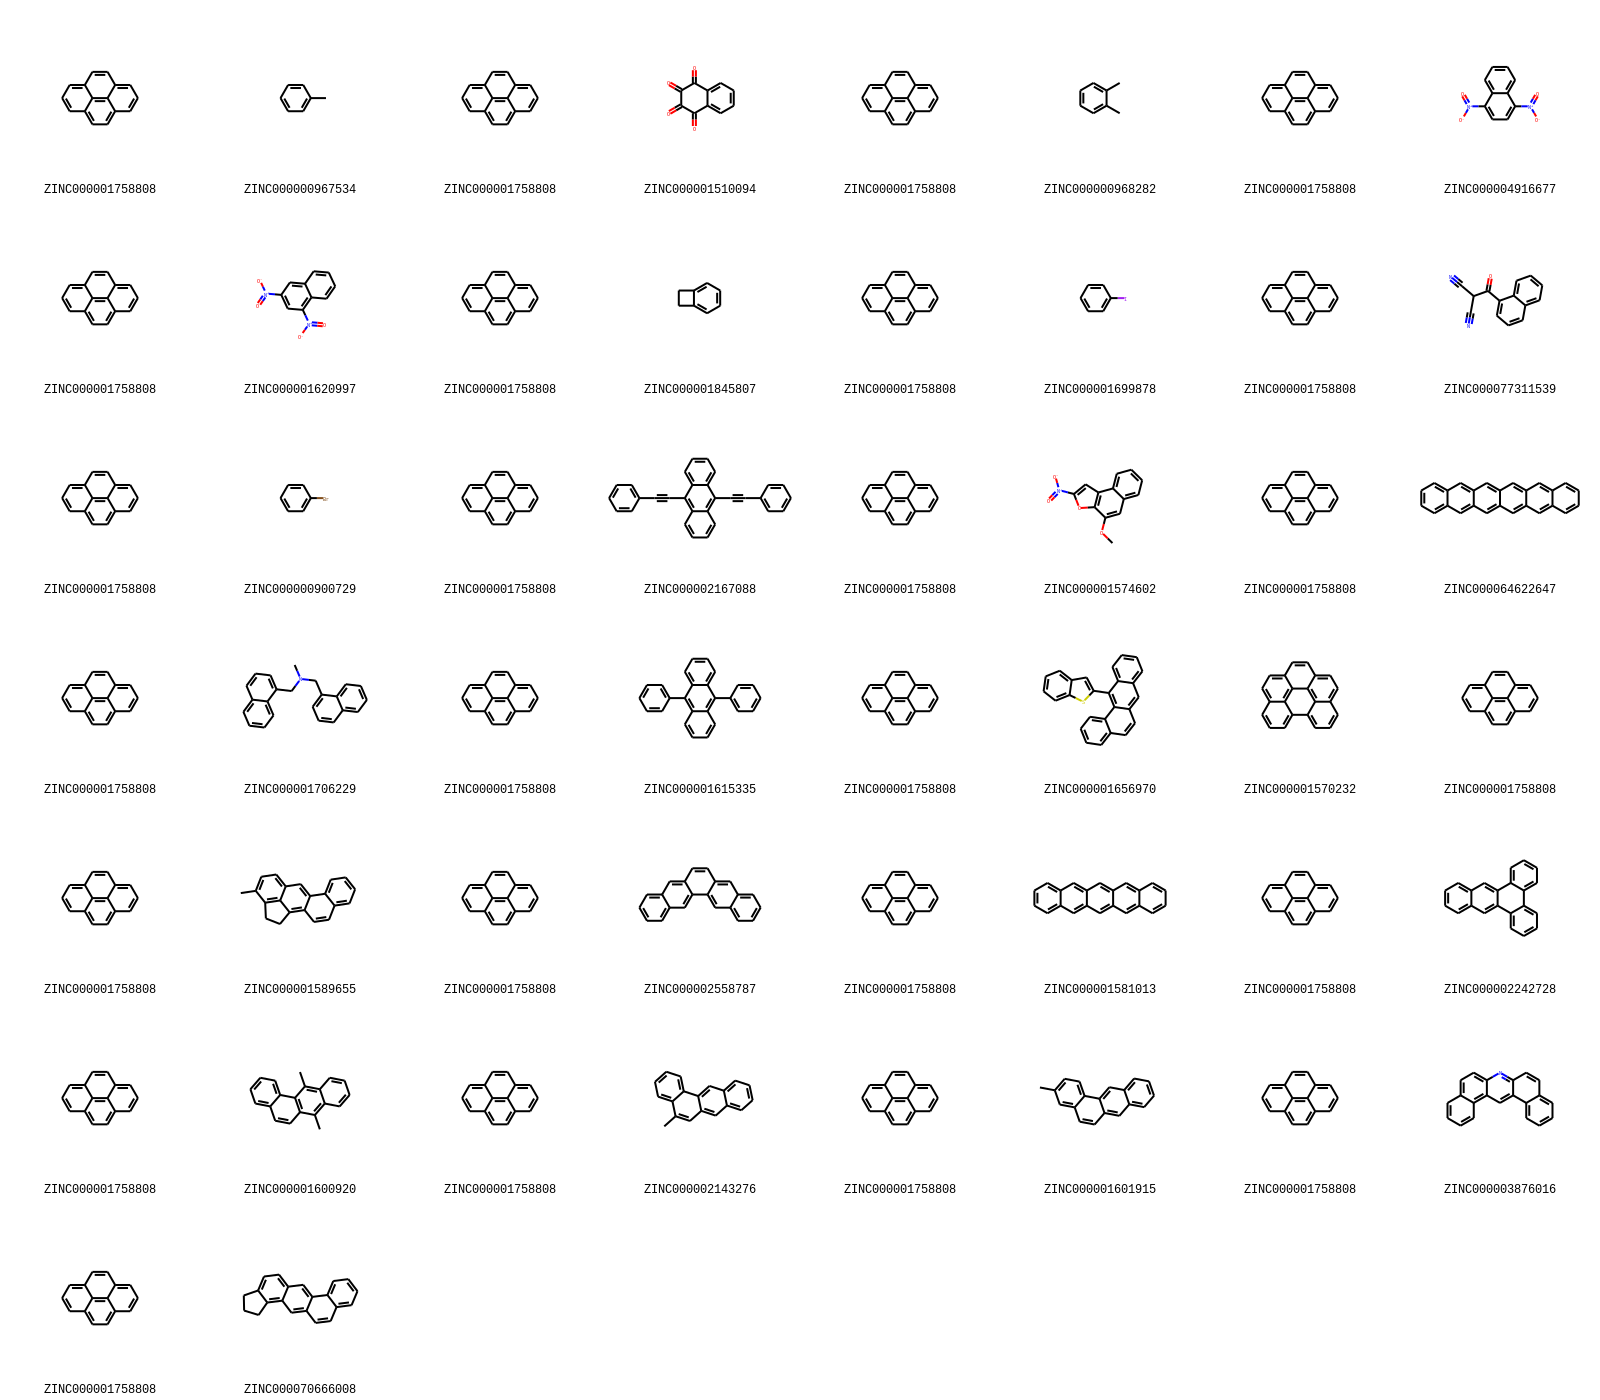

In [ ]:
# Show all the combinatios with  9,10-Anthracenedicarbonitrile 

anthdini=[]
for x in b.Identifier:
  if dict1[x][0] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    anthdini.append(x)        
  if dict1[x][1] == 'c1cc2ccc3cccc4ccc(c1)c2c34':
    anthdini.append(x)

anthdini= Remove(anthdini)    
print('Number of combinations:',len(anthdini))
listaki=[]
score=[]


for i in anthdini[:]:                      # select the number of the predictions you want to see
  #score.append(b[b.comb ==i].test_score)
  listaki.append(dict1[i])
   
ar=np.array(listaki)
ar=ar.tolist()

import itertools

merged = list(itertools.chain(*ar))
subms = [Chem.MolFromSmiles(x) for x in merged]
img=Draw.MolsToGridImage(subms,molsPerRow=8,subImgSize=(200,200),legends=[zinc_dict[x] for x in merged])
img

In [ ]:
c=pd.DataFrame(top.describe().loc['75%'].astype(float)).iloc[0].values[0]
proba_ = top.sort_values(by = ['test_score'], ascending=True)
b = top[top['test_score'] > c]
print(c)
len(b)
b=b.sort_values(by = ['test_score'], ascending=False)

0.7156233134070215


In [ ]:
predictions = list(b['Identifier'])
len(predictions)
#predictions

5434

In [ ]:
listaki=[]
for i in predictions[:]: #both:
  #score.append(b.test_score)
  #print(dict[i])
  listaki.append(dict1[i])

In [ ]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C', 'Clc1ccccc1']

data2 = pd.DataFrame(listaki)[:].iloc[:, 1]
sol = [x for x in data2 if x in solvents]
data2= pd.DataFrame(sol, columns=['count'])
data2 = pd.DataFrame(data2['count'].value_counts())[:20]
data2

count
Cc1ccccc1       158
Cc1ccccc1C      143
C1Cc2ccccc12    141
Clc1ccccc1      115
Brc1ccccc1      105

In [ ]:

#data1 = pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]])
data1 = pd.DataFrame(listaki)[:].iloc[:, 0] # pd.DataFrame(listaki)[:].iloc[:, 1]]
data1 = [x for x in data1.values if x not in solvents]

data1= pd.DataFrame(data1, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:10]

dat1#.index

a
c1cc2ccc3cccc4ccc(c1)c2c34          96
c1ccc2ccccc2c1                      93
c1ccc2c(c1)ccc3ccc4ccccc4c23        93
c1ccc2c(c1)c3cccc4cccc2c34          88
C1=CC2=Cc3cccc4cccc(C=C2C=C1)c34    86
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45  83
Cc1cccc2c1ccc3ccccc23               77
C1=Cc2cc3cccc4ccc5ccc1c2c5c34       77
C1c2ccccc2c3ccc4ccccc4c13           76
Cc1cccc2cccc(C)c12                  76

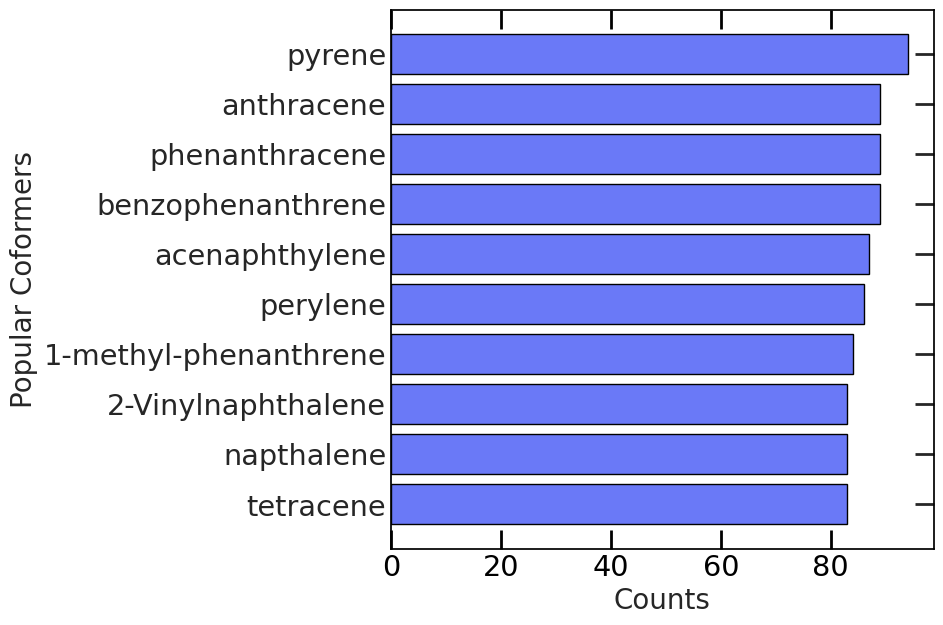

In [ ]:
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'

fig, ax = plt.subplots(figsize=(7,7))
ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['right'].set_color('black')
ax.spines['left'].set_color('black')
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')



x = ['pyrene', 'anthracene',
       'phenanthracene', 'benzophenanthrene',
       'acenaphthylene', 'perylene',
       '1-methyl-phenanthrene', '2-Vinylnaphthalene', 'napthalene',
       'tetracene']

#['c1cc2ccc3cccc4ccc(c1)c2c34 (pyrene)', 'c1ccc2cc3ccccc3cc2c1 (anthracene)',
 #      'c1ccc2c(c1)ccc3ccccc23(phenanthracene)', 'c1ccc2c(c1)ccc3ccc4ccccc4c23 (benzophenanthrene)',
  #     'C1=Cc2cccc3cccc1c23 (  acenaphthylene)', 'c1cc2cccc3c4cccc5cccc(c(c1)c23)c45 (perylene)',
   #    'Cc1cccc2c1ccc3ccccc23 (1-methyl-phenanthrene)', 'C=Cc1ccc2ccccc2c1 (2-Vinylnaphthalene)', 'c1ccc2ccccc2c1 (napthalene)',
    #   'c1ccc2cc3cc4ccccc4cc3cc2c1 (tetracene)']
#dat1.index
energy = dat1.a
x_pos = [i for i, _ in enumerate(x)]

idx = np.asarray([i for i in range(len(x))])                 
#ax.set_yticks(idx)
#ax.yaxis.set_label_position("left")
#ax.yaxis.tick_right()

plt.barh(x_pos, energy, color='#6a79f7')
plt.gca().invert_yaxis()
plt.ylabel("Popular Coformers",fontsize=20, fontweight='normal')
plt.xlabel("Counts" ,fontsize=20,  fontweight='normal')

plt.yticks(x_pos, x)
#plt.savefig('bar_pop.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [ ]:
predictions = list(b['Identifier'])
len(predictions)
listaki=[]
for i in predictions[:]: #both:
  listaki.append(dict1[i])

In [ ]:
solvents = ['C1Cc2ccccc12', 'Brc1ccccc1', 'c1ccc2cnncc2c1', 'Cc1ccccc1', 'Cc1ccccc1C']

data2 = pd.DataFrame(listaki)[:].iloc[:, 1]
sol = [x for x in data2 if x in solvents]
data2= pd.DataFrame(sol, columns=['count'])
data2 = pd.DataFrame(data2['count'].value_counts())[:20]
data2

count
Cc1ccccc1       158
Cc1ccccc1C      139
C1Cc2ccccc12    132
Brc1ccccc1      103

In [ ]:
data1 = pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]])
data1= pd.DataFrame(data1.values, columns=['a'])
dat1 = pd.DataFrame(data1['a'].value_counts())[:20]
#data.groupby(['a']).count()
#data['a']
#data2= pd.DataFrame(data2.values, columns=['a'])
#dat2 = pd.DataFrame(data2['a'].value_counts())[:20]

In [ ]:
dat1

a
Cc1ccccc1                       186
Cc1ccccc1C                      164
C1Cc2ccccc12                    151
Brc1ccccc1                      131
Ic1ccccc1                       121
c1ccc2cccc2cc1                  119
Cc1ccc2c(ccc3cc4ccccc4cc23)c1   112
Cc1cccc2cc3c(ccc4ccccc34)cc12   112
Cc1cccc2c1ccc3cc4ccccc4cc23     112
Cc1cc2cc3ccccc3cc2c4ccccc14     111
Cc1cccc2cc3ccc4ccccc4c3cc12     111
Cc1ccc2cc3ccc4ccccc4c3cc2c1     111
Cc1c2ccccc2c(C)c3c1ccc4ccccc34  111
Cc1ccc2c(ccc3c4ccccc4ccc23)c1   110
Cc1cc2c3ccccc3ccc2c4ccccc14     110
c1ccc2ccccc2c1                  110
Cc1c2ccccc2cc3c1ccc4ccccc34     109
Cc1cccc2ccc3cc4ccccc4cc3c12     109
COc1ccccc1                      108
Cc1ccc2ccc3c4ccccc4ccc3c2c1     108

In [ ]:
#data =pd.concat([pd.DataFrame(listaki)[:].iloc[:, 0], pd.DataFrame(listaki)[:].iloc[:, 1]], axis=0)
data = pd.DataFrame(listaki)[:].iloc[:, 0]
data= pd.DataFrame(data.values, columns=['a'])
dat = pd.DataFrame(data['a'].value_counts())[:20]
#data.groupby(['a']).count()
#data['a']
dat

a
c1cc2ccc3cccc4ccc(c1)c2c34          100
c1ccc2c(c1)c3cccc4cccc2c34           95
c1cc2cccc3c4cccc5cccc(c(c1)c23)c45   89
c1ccc2ccccc2c1                       87
C1=CC2=Cc3cccc4cccc(C=C2C=C1)c34     87
c1ccc2c(c1)c3cccc4ccc5cccc2c5c34     86
C1=Cc2cc3cccc4ccc5ccc1c2c5c34        86
c1ccc2c(c1)ccc3ccc4ccccc4c23         84
Cc1cccc2cccc(C)c12                   84
c1cc2c3cccc4ccc5ccc(c1)c2c5c34       80
C1Cc2cc3cccc4ccc5ccc1c2c5c34         78
C1c2ccccc2c3c1ccc4ccccc34            77
c1ccc2c(c1)c3cccc4c5ccccc5cc2c34     77
C1c2ccccc2c3ccc4ccccc4c13            77
C1=Cc2cccc3cccc1c23                  77
Cc1ccc2cc3ccc4ccccc4c3cc2c1          76
c1ccc(cc1)c2c3ccccc3cc4ccccc24       75
c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45     75
Cc1cccc2c1ccc3ccccc23                74
c1ccc2c(c1)ccc3cc4ccc5ccccc5c4cc23   73

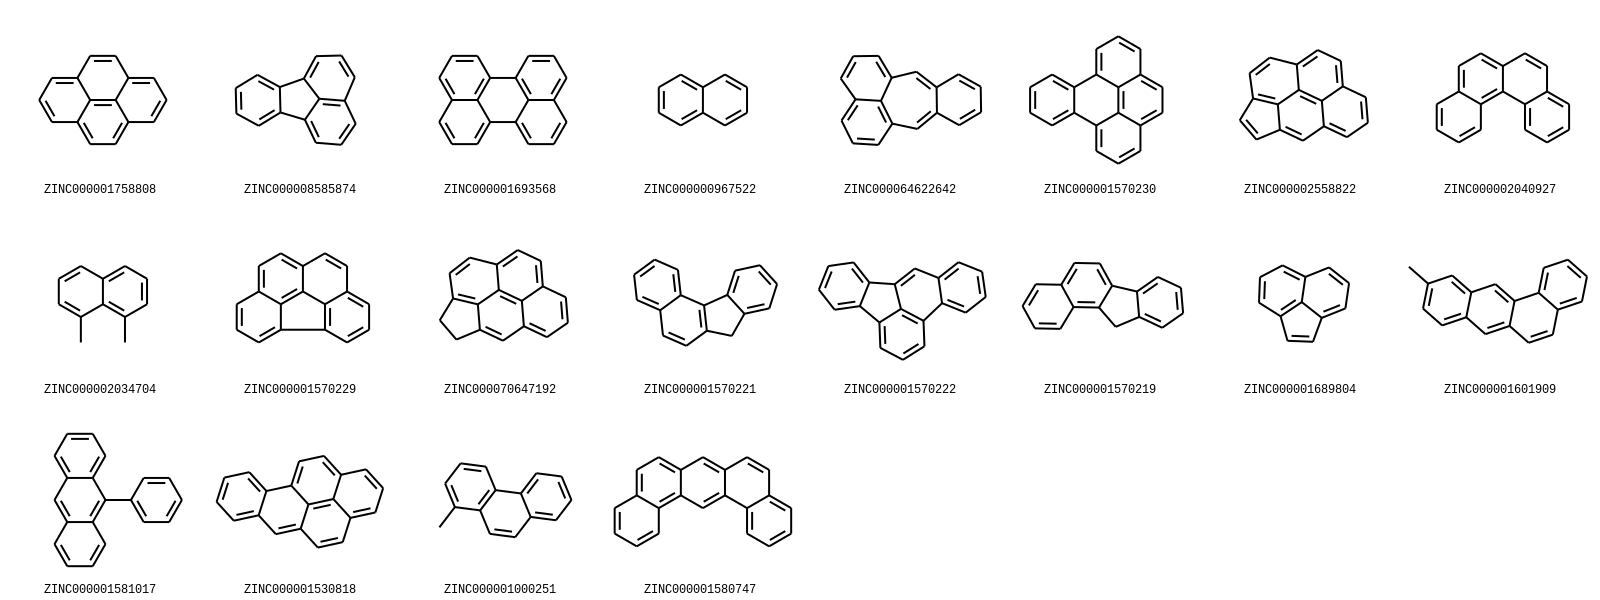

In [ ]:
#smi = ['c1ccc2c(c1)c3cccc4ccc5cccc2c5c34', 'c1cc2ccc3ccc4ccc5cccc6c(c1)c2c3c4c56']
smi= dat.index 
subms1 = [Chem.MolFromSmiles(x) for x in smi]


img=Draw.MolsToGridImage(subms1,molsPerRow=8,subImgSize=(200,200), legends=[zinc_dict[x] for x in smi])
img   

In [ ]:
ens = np.concatenate([lab.iloc[:1722, :].train_score, unlab.test_score])

                      

In [ ]:
# Scatterplot comparing the scores of the ensemble and the deep neural network

lab_deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/labelled_deep.csv')    
unlab_deep_scores =  un.test_score#pd.read_csv('/content/drive/My Drive/cocrystal_design/data/unlabelled_deep.csv')     
ensemble_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/ensemble_scores.csv')       

In [ ]:
deep_scores = pd.read_csv('/content/drive/My Drive/cocrystal_design/data/deep_scores_old.csv')
deep_scores

score
0      0.703429
1      0.316618
2      0.934342
3      0.449260
4      0.484326
...         ...
23453  0.000000
23454  0.482610
23455  0.000000
23456  0.232237
23457  0.427417

[23458 rows x 1 columns]

In [ ]:
lab_deep = lab_deep_scores # pd.read_csv('labelled_deep.csv')
unlab_deep = unlab_deep_scores# pd.read_csv('unlabelled_deep.csv')
unlab_deep[unlab_deep<0] =0
deep = np.concatenate([lab_deep.train_score, unlab_deep.test_score])
ens = ensemble_scores
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.7]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line, columns=['line'])], axis=1)

NameError: ignored

In [ ]:
len(ens)
#len(deep)

23458

In [ ]:
from scipy import stats
deep=deep_scores.score.values
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.7]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data1.deep+intercept
tzaki = pd.concat([pd.DataFrame(data1.deep, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

In [ ]:
data = pd.concat([pd.DataFrame(deep, columns=['deep']), pd.DataFrame(ens, columns=['ens'])], axis=1)
data=data[data.deep>0]
data1 = data[data.deep>0.7]
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
tzaki = pd.concat([pd.DataFrame(data.deep.values, columns=['deep']), pd.DataFrame(line.values, columns=['line'])], axis=1)

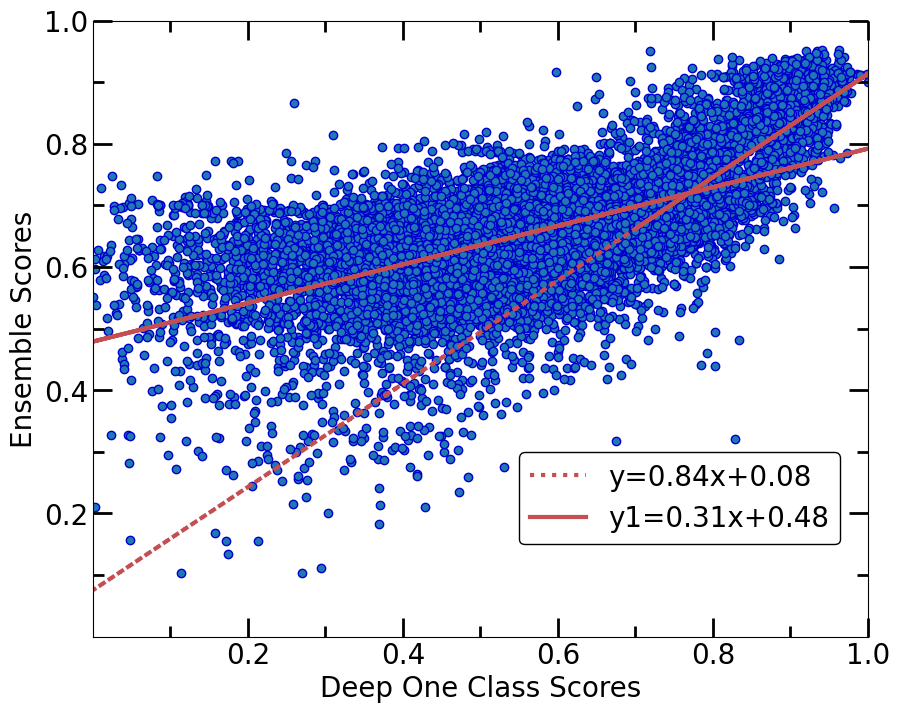

In [ ]:
from matplotlib import rc
import seaborn as sns
import matplotlib.font_manager
#plt.rcParams["font.weight"] = "light"
#plt.rcParams["axes.labelweight"] = "light"
plt.rcParams['axes.facecolor'] = 'white'


plt.style.use('default')
import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "normal"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False

#fig = plt.figure(figsize=(10,8))
fig, ax = plt.subplots(figsize=(10,8))
rcParams["axes.edgecolor"] = "0.15"
rcParams["axes.linewidth"]  = 1.25

plt.scatter(data.deep, data.ens, edgecolors='#0000CC')
slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
#plt.plot(deep, line, 'r', linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))

#plt.legend(loc='lower right')

plt.grid(False)

plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('Deep One Class Scores', fontsize=20)
plt.ylabel('Ensemble Scores', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
# this is an inset axes over the main axes
#a = plt.axes([.6, .15, .28, .28], facecolor='white')
#sns.regplot(x="deep", y="ens", data=data1, color='b',
 #line_kws={'label':"y={0:.1f}x+{1:.1f}".format(slope,intercept), 'color': 'red'})

#plt.scatter(data1.deep, data1.ens, edgecolors='#0000CC')
x= data1.deep
slope, intercept, r_value, p_value, std_err = stats.linregress( data1['deep'] ,data1['ens'])
line = slope*data.deep+intercept
#plt.plot(data.deep, line,  'r', linestyle='-', linewidth=3.0, dashes=(5, 2), label='y1={:.2f}x+{:.2f}'.format(slope,intercept))
plt.plot(tzaki[tzaki.deep > 0.7].deep,tzaki[tzaki.deep > 0.7].line, 'r-',  linewidth=3.0)
plt.plot(tzaki[tzaki.deep < 0.7].deep,tzaki[tzaki.deep < 0.7].line, 'r:',  linewidth=3.0, label='y={:.2f}x+{:.2f}'.format(slope,intercept))


slope, intercept, r_value, p_value, std_err = stats.linregress( data.deep , data.ens)
line = slope*deep+intercept
plt.plot(deep, line, 'r', linewidth=3.0, label='y1={:.2f}x+{:.2f}'.format(slope,intercept))

major_ticks_x = np.arange(0, 1.001, 0.2)
minor_ticks_x = np.arange(0, 1.001, 0.1)
major_ticks_y = np.arange(0, 1.001, 0.2)
minor_ticks_y = np.arange(0, 1.001, 0.1)
ax.tick_params(axis = 'both', which='both', width=2)
ax.tick_params(axis = 'both', which='major', length=14)
ax.tick_params(axis = 'both', which='minor', length=8, color='black')
ax.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction="in")
ax.set_xticks(major_ticks_x)
ax.set_xticks(minor_ticks_x, minor=True)
ax.set_yticks(major_ticks_y)
ax.set_yticks(minor_ticks_y, minor=True)
ax.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax.yaxis.get_major_ticks()[0].draw = lambda *args:None
#plt.title('Probability')
#plt.xticks([])
#plt.yticks([])
plt.legend(prop={'size': 20}, loc=(0.55, 0.15), facecolor='white', edgecolor='black', framealpha=1 )
#plt.savefig('scatter1.png', dpi=600)

# Learning Curves

In [93]:
df1=pd.read_csv('/content/drive/My Drive/cocrystal_design/data/df_reduced.csv')
df1=df.fillna(0)

In [94]:
df1.head() #0.034483

Identifier       nBM      nHet  ...  Eig04_AEA(dm).1   nHAcc.1      Uc.1
0     WOVMEB  0.034483  0.000000  ...         0.667916  0.000000  0.796001
1     PIWKEL  0.057471  0.088889  ...         0.668781  0.000000  0.268420
2     OTIHIJ  0.195402  0.044444  ...         0.010378  0.000000  0.376728
3     DABLOJ  0.005747  0.044444  ...         0.715624  0.131579  0.607167
4     PIGJUK  0.074713  0.088889  ...         0.712165  0.105263  0.464233

[5 rows x 49 columns]

In [39]:
# Import all models
from pyod.models.abod import ABOD
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.ocsvm import OCSVM
from pyod.models.cblof import CBLOF
from sklearn.mixture import GaussianMixture
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from sklearn.metrics import check_scoring
from joblib import Parallel, delayed
from sklearn.utils.validation import _check_fit_params
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _translate_train_sizes
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator
from contextlib import suppress
from sklearn.model_selection import ShuffleSplit
import numbers
import warnings


In [40]:
# Built an ensemble of all the implemented algorithms
from sklearn.base import BaseEstimator

class Ensemble(BaseEstimator):
  def __init__(self, classifiers):
    self.classifiers = classifiers

  def fit(self, X, y):
    for clf in classifiers.values():
      clf.fit(X, y)

  def predict(self, X):
    scores = []
    for clf in classifiers.values():
      scores.append(clf.predict(X))
     
    return (np.mean(scores, 0) >= 0.5).astype('int').ravel()


In [41]:
# Built the Gaussian Mixture Classifier to be used for anomaly detection
from sklearn.base import BaseEstimator
contamination =0.05


class GMM(GaussianMixture):
  def __init__(self, n_components, covariance_type, random_state):
    super().__init__(n_components=n_components , covariance_type=covariance_type, random_state=random_state)

  def fit(self, X, y):
    super().fit(X, y)
    self.prob = super().score_samples(X_train)
    self.c = percentile(self.prob, 100 * contamination)

  def predict(self, X):
    scores = []
    proba=super().score_samples(X)
    
    scores =(proba <= self.c).astype('int').ravel()
     
    return scores

In [42]:
from sklearn.utils import (indexable, check_random_state, _safe_indexing,
                     _message_with_time)

from sklearn.model_selection._split import check_cv

from sklearn.base import is_classifier, clone
from sklearn.metrics import check_scoring
from joblib import Parallel, delayed
from sklearn.utils.validation import _check_fit_params
import time
from sklearn.utils.metaestimators import _safe_split
from sklearn.model_selection._validation import _translate_train_sizes
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
from contextlib import suppress
import numbers
import warnings

In [43]:
def _fit_and_score(estimator, X, y, scorer, train, test, verbose,
                   parameters, fit_params, return_train_score=False,
                   return_parameters=False, return_n_test_samples=False,
                   return_times=False, return_estimator=False,
                   error_score=np.nan):

    if verbose > 1:
        if parameters is None:
            msg = ''
        else:
            msg = '%s' % (', '.join('%s=%s' % (k, v)
                          for k, v in parameters.items()))
        print("[CV] %s %s" % (msg, (64 - len(msg)) * '.'))

    # Adjust length of sample weights
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    train_scores = {}
    if parameters is not None:
        # clone after setting parameters in case any parameters
        # are estimators (like pipeline steps)
        # because pipeline doesn't clone steps in fit
        cloned_parameters = {}
        for k, v in parameters.items():
            cloned_parameters[k] = clone(v, safe=False)

        estimator = estimator.set_params(**cloned_parameters)

    start_time = time.time()

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_train = pd.concat([X_train, pd.concat([X_train.iloc[:, 24:], X_train.iloc[:, :24]], axis=1)]) #pd.concat([X_train.iloc[:, :24], X_train.iloc[:, 24:]], axis=1),
    y_train = np.concatenate([y_train, y_train])
    X_test, y_test = _safe_split(estimator, X, y, test, train)

    try:
        if y_train is None:
            estimator.fit(X_train, **fit_params)
        else:
            estimator.fit(X_train, y_train, **fit_params)

    except Exception as e:
        # Note fit time as time until error
        fit_time = time.time() - start_time
        score_time = 0.0
        if error_score == 'raise':
            raise
        elif isinstance(error_score, numbers.Number):
            if isinstance(scorer, dict):
                test_scores = {name: error_score for name in scorer}
                if return_train_score:
                    train_scores = test_scores.copy()
            else:
                test_scores = error_score
                if return_train_score:
                    train_scores = error_score
            warnings.warn("Estimator fit failed. The score on this train-test"
                          " partition for these parameters will be set to %f. "
                          "Details: \n%s" %
                          (error_score, format_exception_only(type(e), e)[0]),
                          FitFailedWarning)
        else:
            raise ValueError("error_score must be the string 'raise' or a"
                             " numeric value. (Hint: if using 'raise', please"
                             " make sure that it has been spelled correctly.)")

    else:
        fit_time = time.time() - start_time
        test_scores = _score(estimator, X_test, y_test, scorer)
        score_time = time.time() - start_time - fit_time
        if return_train_score:
            train_scores = _score(estimator, X_train, y_train, scorer)
    if verbose > 2:
        if isinstance(test_scores, dict):
            for scorer_name in sorted(test_scores):
                msg += ", %s=" % scorer_name
                if return_train_score:
                    msg += "(train=%.3f," % train_scores[scorer_name]
                    msg += " test=%.3f)" % test_scores[scorer_name]
                else:
                    msg += "%.3f" % test_scores[scorer_name]
        else:
            msg += ", score="
            msg += ("%.3f" % test_scores if not return_train_score else
                    "(train=%.3f, test=%.3f)" % (train_scores, test_scores))

    if verbose > 1:
        total_time = score_time + fit_time
        print(_message_with_time('CV', msg, total_time))

    ret = [train_scores, test_scores] if return_train_score else [test_scores]

    if return_n_test_samples:
        ret.append(_num_samples(X_test))
    if return_times:
        ret.extend([fit_time, score_time])
    if return_parameters:
        ret.append(parameters)
    if return_estimator:
        ret.append(estimator)
    return ret


def _score(estimator, X_test, y_test, scorer):
    """Compute the score(s) of an estimator on a given test set.
    Will return a dict of floats if `scorer` is a dict, otherwise a single
    float is returned.
    """
    if isinstance(scorer, dict):
        # will cache method calls if needed. scorer() returns a dict
        scorer = _MultimetricScorer(**scorer)
    if y_test is None:
        scores = scorer(estimator, X_test)
    else:
        scores = scorer(estimator, X_test, y_test)

    error_msg = ("scoring must return a number, got %s (%s) "
                 "instead. (scorer=%s)")
    if isinstance(scores, dict):
        for name, score in scores.items():
            if hasattr(score, 'item'):
                with suppress(ValueError):
                    # e.g. unwrap memmapped scalars
                    score = score.item()
            if not isinstance(score, numbers.Number):
                raise ValueError(error_msg % (score, type(score), name))
            scores[name] = score
    else:  # scalar
        if hasattr(scores, 'item'):
            with suppress(ValueError):
                # e.g. unwrap memmapped scalars
                scores = scores.item()
        if not isinstance(scores, numbers.Number):
            raise ValueError(error_msg % (scores, type(scores), scorer))
    return scores


In [44]:
def learning_curve(estimator, X, y, groups=None,
                   train_sizes=np.linspace(0.1, 1.0, 5), cv=None,
                   scoring=None, exploit_incremental_learning=False,
                   n_jobs=None, pre_dispatch="all", verbose=0, shuffle=False,
                   random_state=None, error_score=np.nan, return_times=False):
  
    X, y, groups = indexable(X, y, groups)

    if exploit_incremental_learning and not hasattr(estimator, "partial_fit"):
        raise ValueError("An estimator must support the partial_fit interface "
                         "to exploit incremental learning")
    X, y, groups = indexable(X, y, groups)

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    # Store it as list as we will be iterating over the list multiple times
    cv_iter = list(cv.split(X, y, groups))

    scorer = check_scoring(estimator, scoring=scoring)

    n_max_training_samples = len(cv_iter[0][0])
    # Because the lengths of folds can be significantly different, it is
    # not guaranteed that we use all of the available training data when we
    # use the first 'n_max_training_samples' samples.
    train_sizes_abs = _translate_train_sizes(train_sizes,
                                             n_max_training_samples)
    n_unique_ticks = train_sizes_abs.shape[0]
    if verbose > 0:
        print("[learning_curve] Training set sizes: " + str(train_sizes_abs))

    parallel = Parallel(n_jobs=n_jobs, pre_dispatch=pre_dispatch,
                        verbose=verbose)

    if shuffle:
        rng = check_random_state(random_state)
        cv_iter = ((rng.permutation(train), test) for train, test in cv_iter)

    if exploit_incremental_learning:
        classes = np.unique(y) if is_classifier(estimator) else None
        out = parallel(delayed(_incremental_fit_estimator)(
            clone(estimator), X, y, classes, train, test, train_sizes_abs,
            scorer, verbose, return_times) for train, test in cv_iter)
    else:
        train_test_proportions = []
        for train, test in cv_iter:
            for n_train_samples in train_sizes_abs:
                train1 = train[:n_train_samples]
                train_test_proportions.append((train1, test))

        out = parallel(delayed(_fit_and_score)(
            clone(estimator), X, y, scorer, train, test, verbose,
            parameters=None, fit_params=None, return_train_score=True,
            error_score=error_score, return_times=return_times)
            for train, test in train_test_proportions)
        out = np.array(out)
        n_cv_folds = out.shape[0] // n_unique_ticks
        dim = 4 if return_times else 2
        out = out.reshape(n_cv_folds, n_unique_ticks, dim)

    out = np.asarray(out).transpose((2, 1, 0))

    ret = train_sizes_abs, out[0], out[1]

    if return_times:
        ret = ret + (out[2], out[3])

    return ret


In [26]:
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 25, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6), #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=25), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)

}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [ ]:

classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=20, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)

}

In [27]:
classifiers = {
   'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
      # GaussianMixture(n_components=4, covariance_type='full', random_state=None),
   'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),

    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=15), #alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=200,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF':  CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)  # CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

/content/pyod/pyod/models/knn.py:160: FutureWarning: algorithm parameter is deprecated and will be removed in version 0.7.6. By default, ball_tree will be used.
  FutureWarning)


In [46]:
#github repo
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=20, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)

}

In [81]:
#github repo
classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
      'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(alpha=0.5, contamination=0.05, n_bins=8, tol=0.6),# HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)}

In [82]:
# Calculate the learning curves of the Ensemble

#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
df=df.fillna(0)
X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])

clf  = Ensemble(classifiers) 

scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes,# shuffle=True, random_state= 0,
                       return_times=True)

train_sizes = train_sizes*2        
train_scores_mean_ens = np.mean(train_scores, axis=1)*100
train_scores_std_ens = np.std(train_scores, axis=1)*100
test_scores_mean_ens = np.mean(test_scores, axis=1)*100
test_scores_std_ens = np.std(test_scores, axis=1)*100

print(train_sizes)
print(test_scores_mean_ens)
test_scores_std_ens

[  54  196  338  480  622  764  906 1048 1190 1332 1474 1616 1758 1900
 2042 2184 2326 2468 2610 2754]
[74.51937984 74.28901247 70.33838895 75.6223458  81.14206269 84.3892821
 84.09908999 85.66750927 84.68048534 85.08813616 85.95888102 90.48163128
 92.85911695 93.09100101 92.22177283 92.68537243 92.80182002 93.26727334
 92.45348837 92.86012808]


array([18.50608718, 17.01738852, 13.4458292 , 16.28466408, 19.4621035 ,
       14.23040352, 14.84282872, 14.6673986 , 15.42069225, 15.94892797,
       15.41195799,  7.2790755 ,  3.23887009,  2.75610273,  4.3551493 ,
        3.50595967,  3.74697862,  4.01876356,  3.79794048,  3.7385417 ])

In [60]:
test_scores_mean_ens

array([76.26002696, 71.09116953, 70.39703404, 75.50606673, 81.19969666,
       84.27199191, 85.2586788 , 86.30451635, 85.43377149, 85.14391641,
       85.89939333, 89.95837546, 92.39400067, 92.27789012, 91.29271992,
       92.10465116, 92.39518032, 92.16346478, 92.33754634, 92.27957533])

In [ ]:
print(test_scores_mean_ens)

[84.206606   88.38877654 90.30502191 92.79895517 93.14610718 93.08864173
 93.49528143 93.49561847 93.14762386 93.49544995 92.74165824 92.79979778
 93.14863498 93.43950118 93.55527469 93.26457701 93.72952477 93.38119312
 93.96107179 93.78715875]


In [ ]:
print('hi')

hi


In [ ]:
classifiers = {
  # 'Gaussiann Mixture Model (GMM)': GMM(n_components= 2, covariance_type='full', random_state=0), 
      # GaussianMixture(n_components=4, covariance_type='full', random_state=None),
  #  'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20) ,# metric='euclidean', algorithm='kd_tree'),
  #  'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6), #HBOS(contamination=0.05, n_bins=20, alpha=0.5),
 #   'Feature Bagging':
  #      FeatureBagging(LOF(n_neighbors=25), contamination=0.05),
    
   # 'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
   # 'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=10, contamination=0.05)#,
   #  'CBLOF':   CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12)
}

In [ ]:

classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components=4, covariance_type='full', random_state=None), 
     #  GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)': HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=15), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=12) # CBLOF(contamination=0.05,  alpha=0.6, beta=6, n_clusters=9)

}

In [ ]:

classifiers = {
    'Gaussiann Mixture Model (GMM)': GMM(n_components=4, covariance_type='full', random_state=0), 
    #   GaussianMixture(n_components=4, covariance_type='full', random_state=None),
    'K Nearest Neighbors (KNN)': KNN(contamination=0.05, method='mean', n_neighbors= 20, metric='minkowski', algorithm='kd_tree'),
    'Histogram-base Outlier Detection (HBOS)':HBOS(contamination=0.05, n_bins=8, alpha=0.9, tol=0.6),# HBOS(contamination=0.05, n_bins=20, alpha=0.5),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=10), contamination=0.05),
    
    'Isolation Forest': IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=400,  max_features=1.0, max_samples=1000), #IForest(behaviour="new", bootstrap=False, contamination=0.05, n_estimators=300),
    'One class SVM (OCSVM)': OCSVM(contamination=0.05, kernel='rbf' , nu= 0.5, degree=10, gamma=6), # OCSVM(contamination=0.05, kernel='rbf' , nu=0.2 , degree=10, gamma=6), #OCSVM(contamination=0.05, kernel='rbf' , nu=0.2, degree=6, gamma=0.2),
    'Local Outlier Factor (LOF)':
       LOF(n_neighbors=5, contamination=0.05),
     'CBLOF': CBLOF(contamination=0.05,  alpha=0.9, beta=4, n_clusters=9)#  CBLOF(contamination=0.05,  alpha=0.6, beta=6, n_clusters=9)

}

In [83]:
#from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import accuracy_score
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

accuracy=[]
std=[]
df=df.fillna(0)
X_train=df.iloc[:1722, 1:]
y=np.zeros(X_train.shape[0])
scoring = make_scorer(accuracy_score)
train_sizes=np.linspace(.02, 1.0, 20)

for i, (clf_name, clf) in enumerate(classifiers.items()):
  train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(clf, X_train, y , scoring = scoring ,train_sizes=train_sizes, #shuffle=True, random_state= 0,
                       return_times=True)        
  train_scores_mean = np.mean(train_scores, axis=1)*100
  train_scores_std = np.std(train_scores, axis=1)*100
  test_scores_mean = np.mean(test_scores, axis=1)*100
  test_scores_std = np.std(test_scores, axis=1)*100
  accuracy.append(test_scores_mean)
  std.append(test_scores_std)

In [84]:
accuracy


[array([92.33619818, 92.04769127, 92.22160431, 92.10481968, 91.75547691,
        91.40697674, 91.52258173, 91.63919784, 91.34917425, 91.40562858,
        90.82507583, 90.88388945, 89.95483654, 90.18705763, 89.60701045,
        91.34984833, 91.75682508, 90.59555106, 91.23373778, 91.92989552]),
 array([84.67997978, 75.03859117, 69.05645433, 71.78665319, 79.4553421 ,
        83.86383552, 85.54769127, 86.47623862, 85.54836535, 86.12959218,
        86.1875632 , 88.67997978, 91.40562858, 91.34765757, 91.40529154,
        91.46393664, 91.98651837, 91.98634985, 91.58004719, 91.75412875]),
 array([84.51584092, 85.85119649, 82.59571958, 84.33906303, 86.31479609,
        86.48820357, 86.48854061, 86.48854061, 86.4305696 , 86.31445905,
        86.6041456 , 88.28530502, 93.15487024, 93.03875969, 92.80653859,
        92.80637007, 92.98011459, 92.74823054, 92.16801483, 92.10987529]),
 array([67.95062353, 65.92366026, 71.67374452, 78.93511965, 82.77030671,
        86.70542636, 84.67256488, 82.87125042

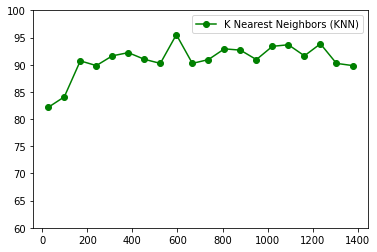

In [ ]:
plt.plot(train_sizes, np.array(accuracy).ravel(), 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
plt.ylim(60,100)
plt.legend()

In [50]:
deepsvdd_acc = [85.36889114, 94.77367711, 95.06403775, 94.25008426, 94.89079879, 94.77249747, 94.657061, 93.96140883, 93.8454668,  94.07650826, 94.25143242 ,93.03252444
, 94.25109538, 93.67054264 ,93.96140883 ,94.01887428, 93.61375126, 93.08914729, 93.49629255, 93.48297944]
deep_svdd_std = np.array([4.74971212, 1.38529559, 1.61241214, 0.81464734, 1.41196402,
       0.80678352, 1.28138832, 0.9192443 , 1.02254341, 0.47323004,
       1.04253551, 1.42801658, 0.49694529, 0.92202131, 0.73618314,
       1.07790345, 1.23603491, 0.70017827, 0.81086377, 0.36964693])

In [85]:
deepsvdd_acc = [84.66734075, 84.26879002, 92.0421301 , 91.22918773, 92.85810583,
       93.26440849, 92.50859454, 93.3810246 , 93.20677452, 93.6107179 ,
       93.20508932, 94.13498483, 93.20728008, 93.90343782, 94.59942703,
       94.42517695, 93.32237951, 93.20626896, 93.49662959, 93.6132457]

deep_svdd_std =np.array([3.91160547, 6.77381165, 2.51618284, 2.86937534, 0.93978505,
       1.43462374, 0.72230273, 1.38603587, 1.63400124, 1.12456403,
       1.36012832, 1.85533401, 1.44445222, 2.35986316, 0.9290437 ,
       1.0296864 , 1.25627334, 0.80752017, 1.47298028, 1.56453667])

In [86]:
# Combine all the accuracy scores 
accuracy.append(test_scores_mean_ens)
accuracy.append(deepsvdd_acc)
std.append(test_scores_std_ens)
std.append(deep_svdd_std)

In [87]:

accuracy 

[array([92.33619818, 92.04769127, 92.22160431, 92.10481968, 91.75547691,
        91.40697674, 91.52258173, 91.63919784, 91.34917425, 91.40562858,
        90.82507583, 90.88388945, 89.95483654, 90.18705763, 89.60701045,
        91.34984833, 91.75682508, 90.59555106, 91.23373778, 91.92989552]),
 array([84.67997978, 75.03859117, 69.05645433, 71.78665319, 79.4553421 ,
        83.86383552, 85.54769127, 86.47623862, 85.54836535, 86.12959218,
        86.1875632 , 88.67997978, 91.40562858, 91.34765757, 91.40529154,
        91.46393664, 91.98651837, 91.98634985, 91.58004719, 91.75412875]),
 array([84.51584092, 85.85119649, 82.59571958, 84.33906303, 86.31479609,
        86.48820357, 86.48854061, 86.48854061, 86.4305696 , 86.31445905,
        86.6041456 , 88.28530502, 93.15487024, 93.03875969, 92.80653859,
        92.80637007, 92.98011459, 92.74823054, 92.16801483, 92.10987529]),
 array([67.95062353, 65.92366026, 71.67374452, 78.93511965, 82.77030671,
        86.70542636, 84.67256488, 82.87125042

In [88]:
train_sizes = train_sizes*2

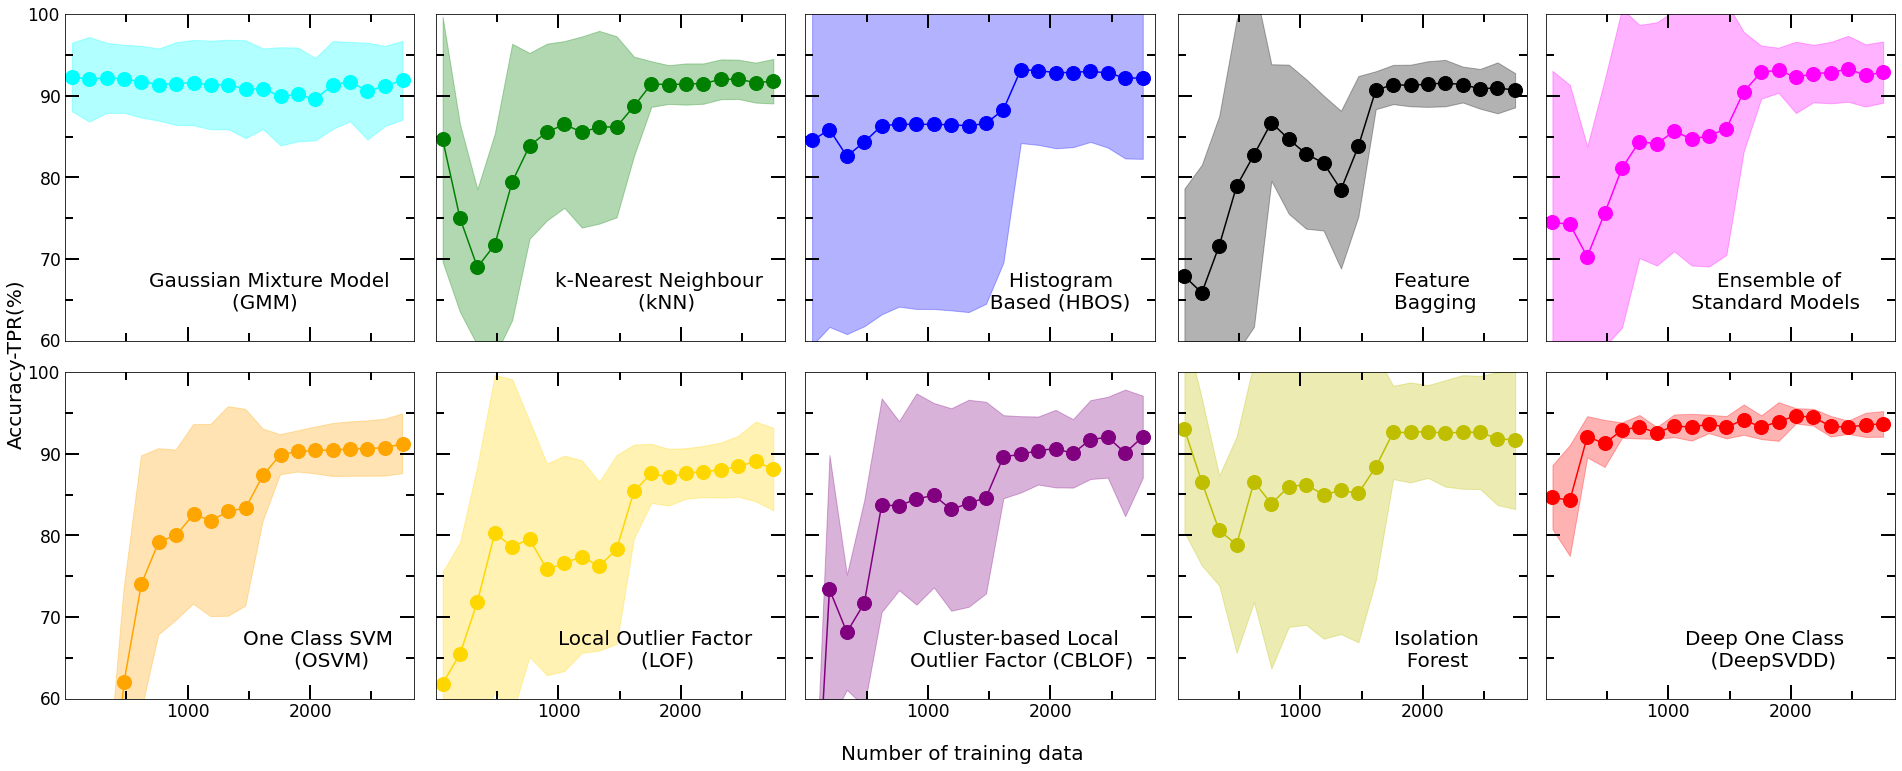

In [89]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt

fig, axes = plt.subplots(figsize=(26,10),nrows=2, ncols=5,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9 = axes.flatten()

colors = ['red', 'tan']
ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", markersize=14, label= 'Gaussiann Mixture Model (GMM)' )
ax0.fill_between(train_sizes,accuracy[0] - std[0],  accuracy[0] + std[0], alpha=0.3,  color="cyan")
ax0.set_ylim(59.9, 100.1)
#ax0.set_title('Gaussian Mixture Model (GMM)',  fontsize=20, y=1.02) #fontweight='bold',
ax0.set_xlim(130, 2850)
ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax0.yaxis.get_major_ticks()[-1].draw = lambda *args:None
#ax0.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax0.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax0.text(-0.0712, -0.015, '60', transform=ax0.transAxes, fontsize= 17)
ax0.text(-0.11, 0.978, '100', transform=ax0.transAxes, fontsize= 17)

# kNN
ax1.plot(train_sizes, accuracy[1], 'o-', color="g", markersize=14, label= 'K Nearest Neighbors (KNN)' )
ax1.fill_between(train_sizes,accuracy[1] - std[1],  accuracy[1] + std[1], alpha=0.3,  color="g")
ax1.set_ylim(60, 100)
#ax1.set_title('k-Nearest Neighbour  (kNN)',  fontsize=20, y=1.02)  # fontweight='bold',
ax1.set_xlim(130, 2850)
ax1.text(0.34, 0.1, 'k-Nearest Neighbour\n             (kNN)', transform=ax1.transAxes,fontsize=20)
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax1.yaxis.get_major_ticks()[0].draw = lambda *args:None

# HBOS 
ax2.plot(train_sizes, accuracy[2], 'o-', color="b",markersize=14, label= 'Histogram-base Outlier Detection (HBOS)' )
ax2.fill_between(train_sizes, accuracy[2] - std[2],  accuracy[2] + std[2], alpha=0.3,  color="b")
ax2.set_ylim(60, 100)
#ax2.set_title('Histogram Based (HBOS)', fontsize=20, y=1.02)  #fontweight='bold', 
ax2.set_xlim(130, 2850)
ax2.text(0.49, 0.1, '     Histogram\n  Based (HBOS)', transform=ax2.transAxes,fontsize=20)
ax2.spines['bottom'].set_color('black')
ax2.spines['top'].set_color('black')
ax2.spines['right'].set_color('black')
ax2.spines['left'].set_color('black')
ax2.tick_params(axis = 'both', which='both', width=2)
ax2.tick_params(axis='x', colors='black')
ax2.tick_params(axis = 'both', which='major', length=14)
ax2.tick_params(axis = 'both', which='minor', length=8, color='black')
ax2.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax2.set_xticks(major_ticks_x)
ax2.set_xticks(minor_ticks_x, minor=True)
ax2.set_yticks(major_ticks_y)
ax2.set_yticks(minor_ticks_y, minor=True)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax2.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax2.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Feature Bagging
ax3.plot(train_sizes,accuracy[3], 'o-', color="black", markersize=14, label= 'Feature Bagging' )
ax3.fill_between(train_sizes, accuracy[3] - std[3],  accuracy[3] + std[3], alpha=0.3,  color="black")
ax3.set_ylim(60, 100)
#ax3.set_title('Feature Bagging', fontsize=20, y=1.02)  # fontweight='bold',
ax3.set_xlim(130, 2850)
ax3.text(0.62, 0.1, 'Feature\nBagging', transform=ax3.transAxes,fontsize=20)
ax3.spines['bottom'].set_color('black')
ax3.spines['top'].set_color('black')
ax3.spines['right'].set_color('black')
ax3.spines['left'].set_color('black')
ax3.tick_params(axis = 'both', which='both', width=2)
ax3.tick_params(axis='x', colors='black')
ax3.tick_params(axis = 'both', which='major', length=14)
ax3.tick_params(axis = 'both', which='minor', length=8, color='black')
ax3.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax3.set_xticks(major_ticks_x)
ax3.set_xticks(minor_ticks_x, minor=True)
ax3.set_yticks(major_ticks_y)
ax3.set_yticks(minor_ticks_y, minor=True)
ax3.set_xticklabels([])
ax3.set_yticklabels([])
ax3.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax3.yaxis.get_major_ticks()[0].draw = lambda *args:None

# Isolation Forest
ax8.plot(train_sizes,accuracy[4], 'o-', color="y",markersize=14, label= 'Isolation Forest' )
ax8.fill_between(train_sizes,accuracy[4] - std[4],  accuracy[4] + std[4], alpha=0.3,  color="y")
ax8.set_ylim(60, 100)
#ax8.set_title('Isolation Forest',  fontsize=20, y=1.02)  #fontweight='bold',
ax8.set_xlim(130, 2850)
ax8.text(0.62, 0.1, 'Isolation\n  Forest', transform=ax8.transAxes,fontsize=20)
ax8.spines['bottom'].set_color('black')
ax8.spines['top'].set_color('black')
ax8.spines['right'].set_color('black')
ax8.spines['left'].set_color('black')
ax8.tick_params(axis = 'both', which='both', width=2)
ax8.tick_params(axis='x', colors='black')
ax8.tick_params(axis = 'both', which='major', length=14)
ax8.tick_params(axis = 'both', which='minor', length=8, color='black')
ax8.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax8.set_xticks(major_ticks_x)
ax8.set_xticks(minor_ticks_x, minor=True)
ax8.set_yticks(major_ticks_y)
ax8.set_yticks(minor_ticks_y, minor=True)
ax8.set_yticklabels([])
#ax8.set_xticklabels([])  #
ax8.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax8.yaxis.get_major_ticks()[0].draw = lambda *args:None

# OCSVM
ax5.plot(train_sizes, accuracy[5], 'o-', color="orange", markersize= 14, label= 'One class SVM (OCSVM)' )
ax5.fill_between(train_sizes, accuracy[5]- std[5],  accuracy[5] + std[5], alpha=0.3,  color="orange")
ax5.set_ylim(59.9, 100.1)
#ax5.set_title('One Class SVM (OSVM)',fontsize=20, y=1.02) # fontweight='bold', 
ax5.set_xlim(130, 2850)
ax5.text(0.51, 0.1, 'One Class SVM\n        (OSVM)', transform=ax5.transAxes,fontsize=20)
ax5.spines['bottom'].set_color('black')
ax5.spines['top'].set_color('black')
ax5.spines['right'].set_color('black')
ax5.spines['left'].set_color('black')
ax5.tick_params(axis = 'both', which='both', width=2)
ax5.tick_params(axis='x', colors='black')
ax5.tick_params(axis = 'both', which='major', length=14)
ax5.tick_params(axis = 'both', which='minor', length=8, color='black')
ax5.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100.1, 10)
minor_ticks_y = np.arange(60, 100.1, 5)
ax5.set_xticks(major_ticks_x)
ax5.set_xticks(minor_ticks_x, minor=True)
ax5.set_yticks(major_ticks_y)
ax5.set_yticks(minor_ticks_y, minor=True)
ax5.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax5.yaxis.get_major_ticks()[0].draw = lambda *args:None
#ax5.set_xticklabels([])
#ax5.set_yticklabels([])
#ax5.yaxis.majorTicks[0].tick1line.set_markersize(0)
#ax5.yaxis.majorTicks[-1].tick1line.set_markersize(0)
ax5.yaxis.get_major_ticks()[-1].draw = lambda *args:None
ax5.text(-0.0712, -0.015, '60', transform=ax5.transAxes, fontsize= 17)
ax5.text(-0.11, 0.978, '100', transform=ax5.transAxes, fontsize= 17)

# LOF
ax6.plot(train_sizes, accuracy[6], 'o-', color="gold", markersize=14,label= 'Local Outlier Factor (LOF)' )
ax6.fill_between(train_sizes,accuracy[6] - std[6],  accuracy[6] + std[6], alpha=0.3,  color="gold")
ax6.set_ylim(60, 100)
#ax6.set_title('Local Outlier Factor (LOF)',fontsize=20, y=1.02) # fontweight='bold', 
ax6.set_xlim(130, 2850)
ax6.text(0.35, 0.1, 'Local Outlier Factor\n             (LOF)', transform=ax6.transAxes,fontsize=20)
ax6.spines['bottom'].set_color('black')
ax6.spines['top'].set_color('black')
ax6.spines['right'].set_color('black')
ax6.spines['left'].set_color('black')
ax6.tick_params(axis = 'both', which='both', width=2)
ax6.tick_params(axis='x', colors='black')
ax6.tick_params(axis = 'both', which='major', length=14)
ax6.tick_params(axis = 'both', which='minor', length=8, color='black')
ax6.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax6.set_xticks(major_ticks_x)
ax6.set_xticks(minor_ticks_x, minor=True)
ax6.set_yticks(major_ticks_y)
ax6.set_yticks(minor_ticks_y, minor=True)
ax6.set_yticklabels([])
#ax6.set_xticklabels([])
ax6.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax6.yaxis.get_major_ticks()[0].draw = lambda *args:None

# CBLOF
ax7.plot(train_sizes, accuracy[7], 'o-', color="purple",markersize= 14, label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax7.fill_between(train_sizes,accuracy[7] - std[7], accuracy[7] + std[7], alpha=0.3,  color="purple")
ax7.set_ylim(60, 100)
ax7.set_xlim(130, 2850)
ax7.text(0.3, 0.1, '  Cluster-based Local\nOutlier Factor (CBLOF)', transform=ax7.transAxes,fontsize=20)
ax7.spines['bottom'].set_color('black')
ax7.spines['top'].set_color('black')
ax7.spines['right'].set_color('black')
ax7.spines['left'].set_color('black')
ax7.tick_params(axis = 'both', which='both', width=2)
ax7.tick_params(axis='x', colors='black')
ax7.tick_params(axis = 'both', which='major', length=14)
ax7.tick_params(axis = 'both', which='minor', length=8, color='black')
ax7.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax7.set_xticks(major_ticks_x)
ax7.set_xticks(minor_ticks_x, minor=True)
ax7.set_yticks(major_ticks_y)
ax7.set_yticks(minor_ticks_y, minor=True)
ax7.set_yticklabels([])
#ax7.set_xticklabels([])
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax7.yaxis.get_major_ticks()[0].draw = lambda *args:None

# DeepSVDD
ax9.plot(train_sizes, accuracy[9], 'o-', color="r",markersize =14, label= 'DeepSVDD')
ax9.fill_between(train_sizes, accuracy[9] - std[9],  accuracy[9] + std[9], alpha=0.3,  color='r')
ax9.set_ylim(60, 100)
ax9.set_xlim(130, 2850)
#ax9.set_title('DeepSVDD', fontsize=20,  y=1.02) # fontweight='bold',
ax9.text(0.4, 0.1, 'Deep One Class\n    (DeepSVDD)', transform=ax9.transAxes,fontsize=20)
ax9.spines['bottom'].set_color('black')
ax9.spines['top'].set_color('black')
ax9.spines['right'].set_color('black')
ax9.spines['left'].set_color('black')
ax9.tick_params(axis = 'both', which='both', width=2)
ax9.tick_params(axis='x', colors='black')
ax9.tick_params(axis = 'both', which='major', length=14)
ax9.tick_params(axis = 'both', which='minor', length=8, color='black')
ax9.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax9.set_xticks(major_ticks_x)
ax9.set_xticks(minor_ticks_x, minor=True)
ax9.set_yticks(major_ticks_y)
ax9.set_yticks(minor_ticks_y, minor=True)
ax9.set_yticklabels([])
#ax9.set_xticklabels([])
ax9.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax9.yaxis.get_major_ticks()[0].draw = lambda *args:None


# Ensemble
ax4.plot(train_sizes, accuracy[8], 'o-', markersize=14, color="magenta", label='Ensemble') 
ax4.fill_between(train_sizes, accuracy[8] - std[8],  accuracy[8] + std[8], alpha=0.3,  color="magenta")
ax4.set_ylim(60, 100)
ax4.set_xlim(130, 2850)
#ax4.set_title('Ensemble of Standard Models',fontsize=20, y=1.02 ) # fontweight='bold', 
ax4.text(0.4, 0.1, '     Ensemble of\n Standard Models', transform=ax4.transAxes,fontsize=20)
ax4.spines['bottom'].set_color('black')
ax4.spines['top'].set_color('black')
ax4.spines['right'].set_color('black')
ax4.spines['left'].set_color('black')
ax4.tick_params(axis = 'both', which='both', width=2)
ax4.tick_params(axis='x', colors='black')
ax4.tick_params(axis = 'both', which='major', length=14)
ax4.tick_params(axis = 'both', which='minor', length=8, color='black')
ax4.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(60, 100, 10)
minor_ticks_y = np.arange(60, 100, 5)
ax4.set_xticks(major_ticks_x)
ax4.set_xticks(minor_ticks_x, minor=True)
ax4.set_yticks(major_ticks_y)
ax4.set_yticks(minor_ticks_y, minor=True)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.xaxis.get_major_ticks()[0].draw = lambda *args:None
ax4.yaxis.get_major_ticks()[0].draw = lambda *args:None


import matplotlib.font_manager
rcParams["font.weight"] = "normal"
rcParams["axes.labelweight"] = "normal"
rcParams['font.family'] = 'sans-serif'
rcParams["font.sans-serif"] = "Helvetica"
rcParams["axes.labelsize"] = "xx-large"
rcParams["axes.labelweight"]= "bold"
rcParams["xtick.labelsize"] = "xx-large"
rcParams["ytick.labelsize"] = "xx-large"
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid']=False
rcParams['patch.edgecolor'] = 'black'


#fig.tight_layout()
fig.text(0.5, -0.05, 'Number of training data', ha='center',fontsize=20 )
fig.text(-0.01, 0.5, 'Accuracy-TPR(%)', va='center', rotation='vertical', fontsize=20)

#plt.savefig('figure4_new.png', rasterized=True,  bbox_inches="tight", dpi=600)
plt.show()

In [91]:
df.head()

Identifier       nBM      nHet  ...  Eig04_AEA(dm).1   nHAcc.1      Uc.1
0     WOVMEB  0.034483  0.000000  ...         0.667916  0.000000  0.796001
1     PIWKEL  0.057471  0.088889  ...         0.668781  0.000000  0.268420
2     OTIHIJ  0.195402  0.044444  ...         0.010378  0.000000  0.376728
3     DABLOJ  0.005747  0.044444  ...         0.715624  0.131579  0.607167
4     PIGJUK  0.074713  0.088889  ...         0.712165  0.105263  0.464233

[5 rows x 49 columns]

In [ ]:
deep=[83.27165487, 91.57751938, 93.26407145, 92.21991911, 91.86956522,
        92.27789012, 91.11678463, 92.45230873, 92.39214695, 93.90394338,
        92.68402427, 93.32103134, 91.87158746, 92.68419279, 92.39231547,
        93.20559488, 91.6966633 , 93.38068756, 92.85911695, 93.08897877]

Text(0.33, -0.05, 'Number of training data')

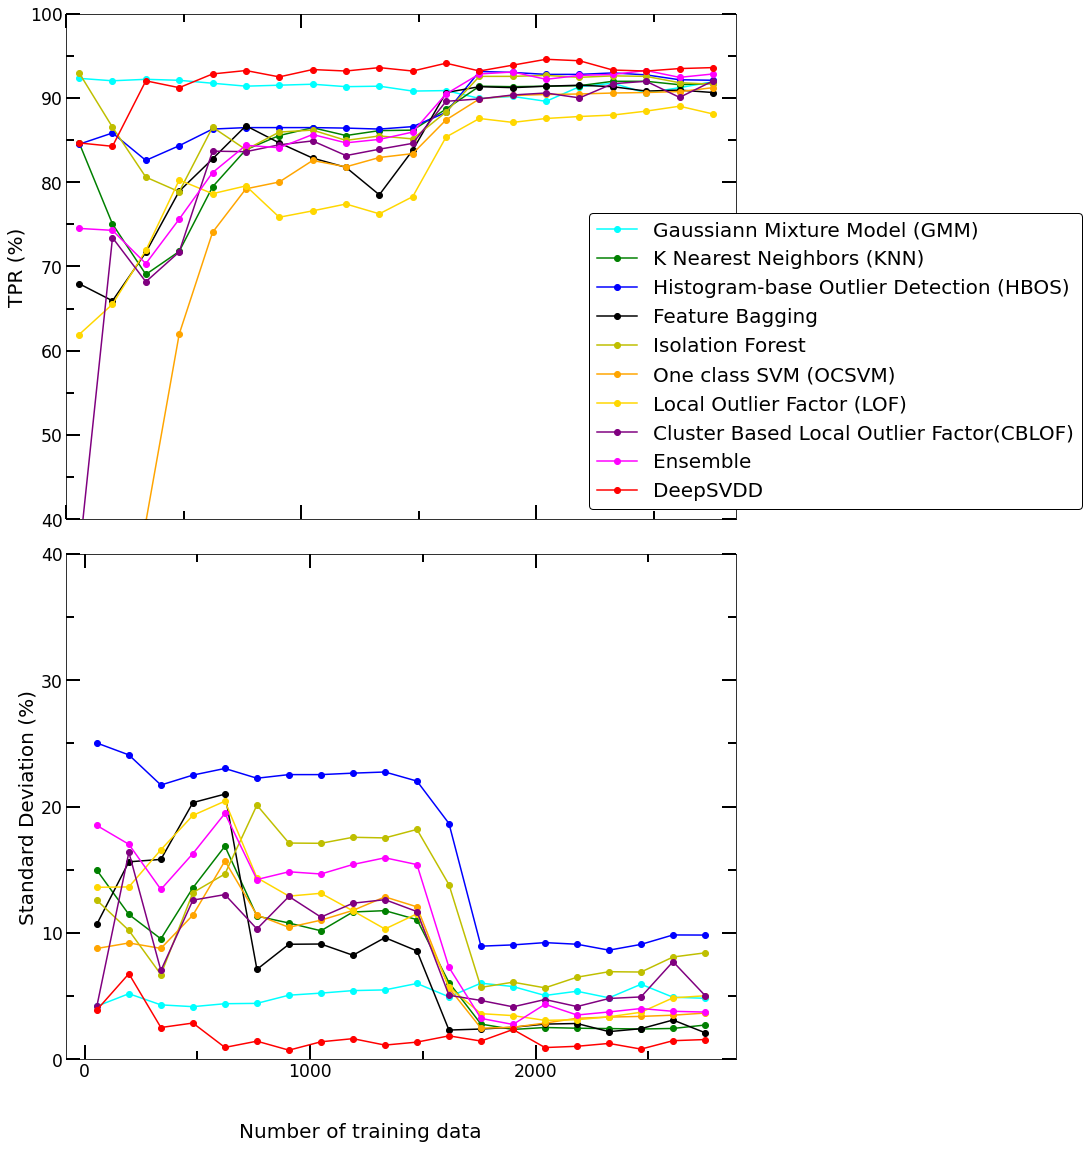

In [90]:
# Construct histograms showing the scores distribution of the labeled/unlabeled data for each algorithm used
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
fig, axes = plt.subplots(figsize=(15,15),nrows=2, ncols=1,constrained_layout=True, gridspec_kw = {'wspace':0.25, 'hspace':0.25})

ax0, ax1= axes.flatten()


ax0.plot(train_sizes,accuracy[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax0.plot(train_sizes, accuracy[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax0.plot(train_sizes, accuracy[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax0.plot(train_sizes,accuracy[3], 'o-', color="black", label= 'Feature Bagging' )
ax0.plot(train_sizes,accuracy[4], 'o-', color="y", label= 'Isolation Forest' )
ax0.plot(train_sizes, accuracy[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax0.plot(train_sizes, accuracy[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax0.plot(train_sizes, accuracy[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax0.plot(train_sizes, accuracy[8], 'o-', color="magenta", label='Ensemble') 
ax0.plot(train_sizes, accuracy[9], 'o-', color="red", label= 'DeepSVDD')
ax0.set_ylim(40, 100)
ax0.set_xlim(130, 2850)
#ax0.text(0.24, 0.1, 'Gaussian Mixture Model\n             (GMM)', transform=ax0.transAxes,fontsize=20)
ax0.spines['bottom'].set_color('black')
ax0.spines['top'].set_color('black')
ax0.spines['right'].set_color('black')
ax0.spines['left'].set_color('black')
ax0.tick_params(axis = 'both', which='both', width=2)
ax0.tick_params(axis='x', colors='black')
ax0.tick_params(axis = 'both', which='major', length=14)
ax0.tick_params(axis = 'both', which='minor', length=8, color='black')
ax0.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(40, 100.1, 10)
minor_ticks_y = np.arange(40, 100.1, 5)
ax0.set_xticks(major_ticks_x)
ax0.set_xticks(minor_ticks_x, minor=True)
ax0.set_yticks(major_ticks_y)
ax0.set_yticks(minor_ticks_y, minor=True)
ax0.set_xticklabels([])
#ax0.set_yticklabels([]) 
ax0.set_ylabel('TPR (%)', fontsize=20)


ax1.set_ylim(0, 40)
ax1.plot(train_sizes, std[0], 'o-', color="cyan", label= 'Gaussiann Mixture Model (GMM)' )
ax1.plot(train_sizes, std[1], 'o-', color="g", label= 'K Nearest Neighbors (KNN)' )
ax1.plot(train_sizes, std[2], 'o-', color="b", label= 'Histogram-base Outlier Detection (HBOS)' )
ax1.plot(train_sizes, std[3], 'o-', color="black", label= 'Feature Bagging' )
ax1.plot(train_sizes, std[4], 'o-', color="y", label= 'Isolation Forest' )
ax1.plot(train_sizes, std[5], 'o-', color="orange", label= 'One class SVM (OCSVM)' )
ax1.plot(train_sizes, std[6], 'o-', color="gold", label= 'Local Outlier Factor (LOF)' )
ax1.plot(train_sizes, std[7], 'o-', color="purple", label= 'Cluster Based Local Outlier Factor(CBLOF)' )
ax1.plot(train_sizes, std[8], 'o-', color="magenta", label= 'Ensemble' )
ax1.plot(train_sizes, std[9], 'o-', color="red", label= 'DeepSVDD')
ax1.spines['bottom'].set_color('black')
ax1.spines['top'].set_color('black')
ax1.spines['right'].set_color('black')
ax1.spines['left'].set_color('black')
ax1.tick_params(axis = 'both', which='both', width=2)
ax1.tick_params(axis='x', colors='black')
ax1.tick_params(axis = 'both', which='major', length=14)
ax1.tick_params(axis = 'both', which='minor', length=8, color='black')
ax1.tick_params(axis = 'both', which='both' , bottom=True, top=True, left=True, right=True, direction='in')
major_ticks_x = np.arange(0, 3000, 1000)
minor_ticks_x = np.arange(0, 3000, 500)
major_ticks_y = np.arange(0, 40.1, 10)
minor_ticks_y = np.arange(0, 40.1, 5)
ax1.set_xticks(major_ticks_x)
ax1.set_xticks(minor_ticks_x, minor=True)
ax1.set_yticks(major_ticks_y)
ax1.set_yticks(minor_ticks_y, minor=True)
ax1.set_ylabel('Standard Deviation (%)', fontsize=20)

ax0.legend(prop={'size': 20},  loc=(0.78, 0.02), facecolor='white', framealpha=1, edgecolor='black')

fig.text(0.33, -0.05, 'Number of training data', ha='center',fontsize=20 )
#plt.savefig('learning_curves_si.svg', dpi=300)